In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.linear_model import LinearRegression
from collections import Counter
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import math
from pathlib import Path
import os

In [2]:
## optional
## delete celltypes with cell counts lower than certain amount
## specifing an lower bond is a must
def filter_low_counts(celltype_df, age_df, celltype_col, threshold):
    print("Checking low count cell types...")
    
    celltype_count = Counter(celltype_df[celltype_col])
    for key in celltype_count:
        if threshold == None:
            unique_ages = np.unique(age_df)
            num_groups = (len(unique_ages) + 1) * 100
            if celltype_count[key] < num_groups:
                print(key, " has too low counts")
                celltype_df = celltype_df[celltype_df[celltype_col] != key]
        else:
            if celltype_count[key] < threshold:
                print(key, " has too low counts")
                celltype_df = celltype_df[celltype_df[celltype_col] != key]
    return celltype_df

In [3]:
def _get_skewed_count_info(adata, class_col, age_col, age_threshold):
    print("Checking skewed count cell types...")
    
    # Compute the fraction of cells for each age group within each cell ontology class
    group_counts = adata.obs.groupby([class_col, age_col]).size()
    total_counts = adata.obs.groupby([class_col]).size()
    
    # Calculate the fraction of each age group within each class
    class_age_fraction = group_counts / total_counts
    
    # Find the cell classes to filter out based on age distribution
    classes_to_filter = class_age_fraction[class_age_fraction > age_threshold].index.get_level_values(0).unique()
    
    return classes_to_filter

In [4]:
def read_and_filter_h5ad(filepath, class_col="celltype", age_col="age", filter_gender=True, gender="male", age_threshold=0.8, count_threshold=None):
    """Parameters:
    filepath: path to AnnData object
        The Scanpy AnnData object containing single-cell data.
    class_col: str, optional (default: 'celltype')
        The column name in adata.obs representing the cell ontology class.
    age_col: str, optional (default: 'age')
        The column name in adata.obs representing the age of the cells.
    filter_gender: boolen, optional (default: True)
        Whether you would like to filter a gender out
    gender: str, optional only if the filter_gender is True(default: "male")
        Choose which gender to keep
    age_threshold: float, optional (default: 0.8)
        The threshold fraction for filtering based on age distribution. If one age group has more than this
        fraction of cells in a class, the class will be filtered out.
    count_threshold: int, optional (default: None(100))
        Lower threshold for filtering cell types based on count.
 
    Returns:
    filtered_adata: AnnData object
        The filtered AnnData object with specified cell ontology classes removed based on both criteria."""
    try:
        adata = sc.read_h5ad(filepath)
        
        if filter_gender:
             filtered_adata = adata[adata.obs["sex"] == gender, :].copy()
                
        celltype_df = filtered_adata.obs[[class_col]].copy()
        age_df = filtered_adata.obs[[age_col]].copy()
        
        # Apply the cell count threshold filtering
        celltype_df = _filter_low_counts(celltype_df, age_df, class_col, count_threshold)
    
        # Create a filtered AnnData object based on cell count filtering
        filtered_adata = filtered_adata[celltype_df.index].copy()
        
        # Identify the skewed classes to filter based on age distribution
        classes_to_filter = _get_skewed_count_info(filtered_adata, class_col, age_col, age_threshold)
        
        if len(classes_to_filter):
            print(classes_to_filter[0], " has skewed cell counts")
            
        # Further filter the AnnData object based on age distribution
        final_filtered_adata = filtered_adata[~filtered_adata.obs[class_col].isin(classes_to_filter)].copy()
        
        return final_filtered_adata
    except Exception as e:
        raise(e)

In [5]:
# Get the current working directory, this should get the path automatically
# hope it works for mac
current_dir = Path.cwd()
print(f"Current working directory: {current_dir}")

# Construct full file paths using the `/` operator
file1 = current_dir / "Brain_Myeloid_facs.h5ad"
file2 = current_dir / "Brain_Non-Myeloid_facs.h5ad"
# Print the paths for verification
print(f"File 1 path: {file1}")
print(f"File 2 path: {file2}")

# Verify that files exist
assert file1.is_file(), f"File not found: {file1}"
assert file2.is_file(), f"File not found: {file2}"

# Read and filter the data
adata = read_and_filter_h5ad(str(file1), str(file2), "cell_ontology_class", "age")
print(adata.obs["abs"])

Current working directory: c:\Users\Hang Yu\Desktop\SC_Ageing_Prediction
File 1 path: c:\Users\Hang Yu\Desktop\SC_Ageing_Prediction\Brain_Myeloid_facs.h5ad
File 2 path: c:\Users\Hang Yu\Desktop\SC_Ageing_Prediction\Brain_Non-Myeloid_facs.h5ad


C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\Hang Yu\AppData\Local\Packages

Checking low count cell types...
macrophage  has too low counts
brain pericyte  has too low counts
interneuron  has too low counts
CD8-positive, alpha-beta T cell  has too low counts
Bergmann glial cell  has too low counts
ependymal cell  has too low counts
neuronal stem cell  has too low counts
oligodendrocyte precursor cell  has too low counts
Il6 expressing cells  has too low counts
medium spiny neuron  has too low counts
Checking skewed count cell types...
astrocyte  has skewed cell counts


In [6]:

#preset figure size and font size to latex page size
font_size_config = {
    'axes.titlesize': 8,  # Title font size
    'axes.labelsize': 8,  # Axes labels (x and y) font size
    'xtick.labelsize': 8,  # X-axis tick label font size
    'ytick.labelsize': 8,  # Y-axis tick label font size
}



plt.rcParams.update({'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

# Width and height for a double-column figure in IEEE format
fig_width = 7.16   # width in inches
fig_height = (fig_width / 36) * 16 # height in inches to maintain 9:6 ratio for each subplot

In [7]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=500)
adata

AnnData object with n_obs × n_vars = 9499 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [8]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

AnnData object with n_obs × n_vars = 9499 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [9]:
adata = adata[adata.obs['n_counts']>=3000]
adata

View of AnnData object with n_obs × n_vars = 8816 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scanpy\preprocessing\_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [11]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

AnnData object with n_obs × n_vars = 8816 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [12]:
sc.pp.log1p(adata)

In [13]:
sc.pp.scale(adata, max_value=10, zero_center=False)

In [14]:
sc.tl.pca(adata,use_highly_variable=True)

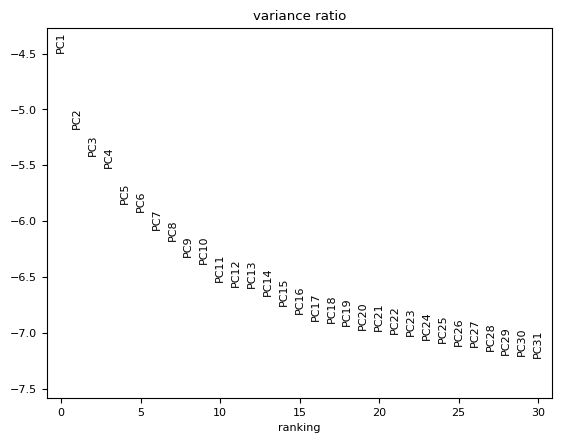

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

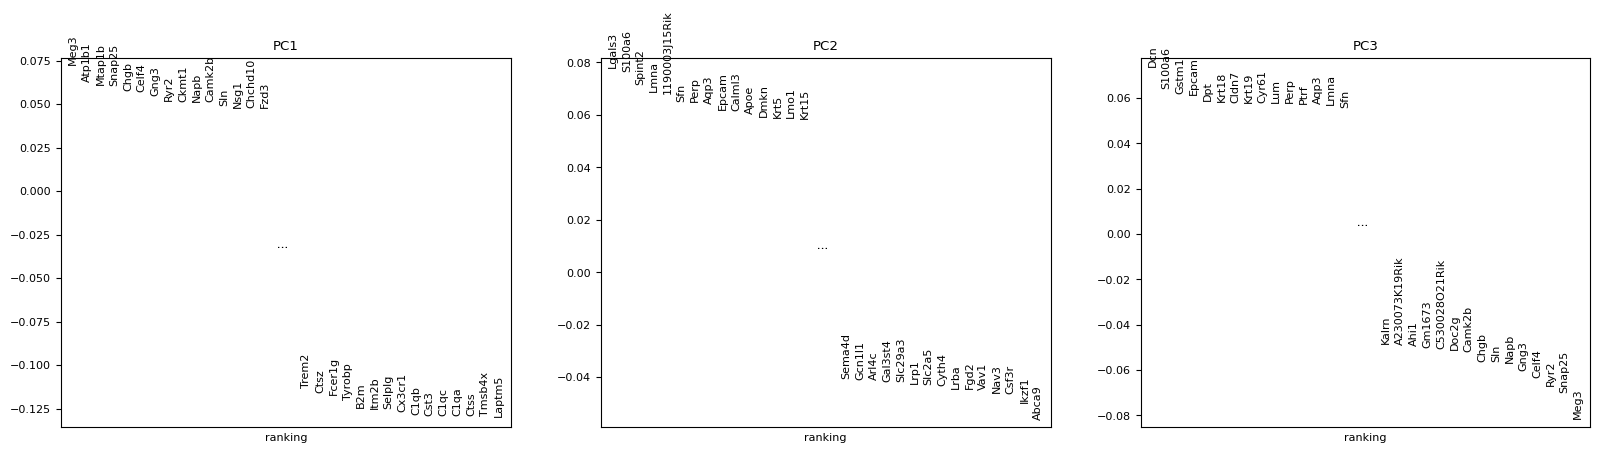

In [16]:
sc.pl.pca_loadings(adata)

In [17]:
sc.pp.neighbors(adata, n_neighbors=18)
sc.tl.louvain(adata, resolution = 1)

C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
sc.tl.umap(adata)

C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


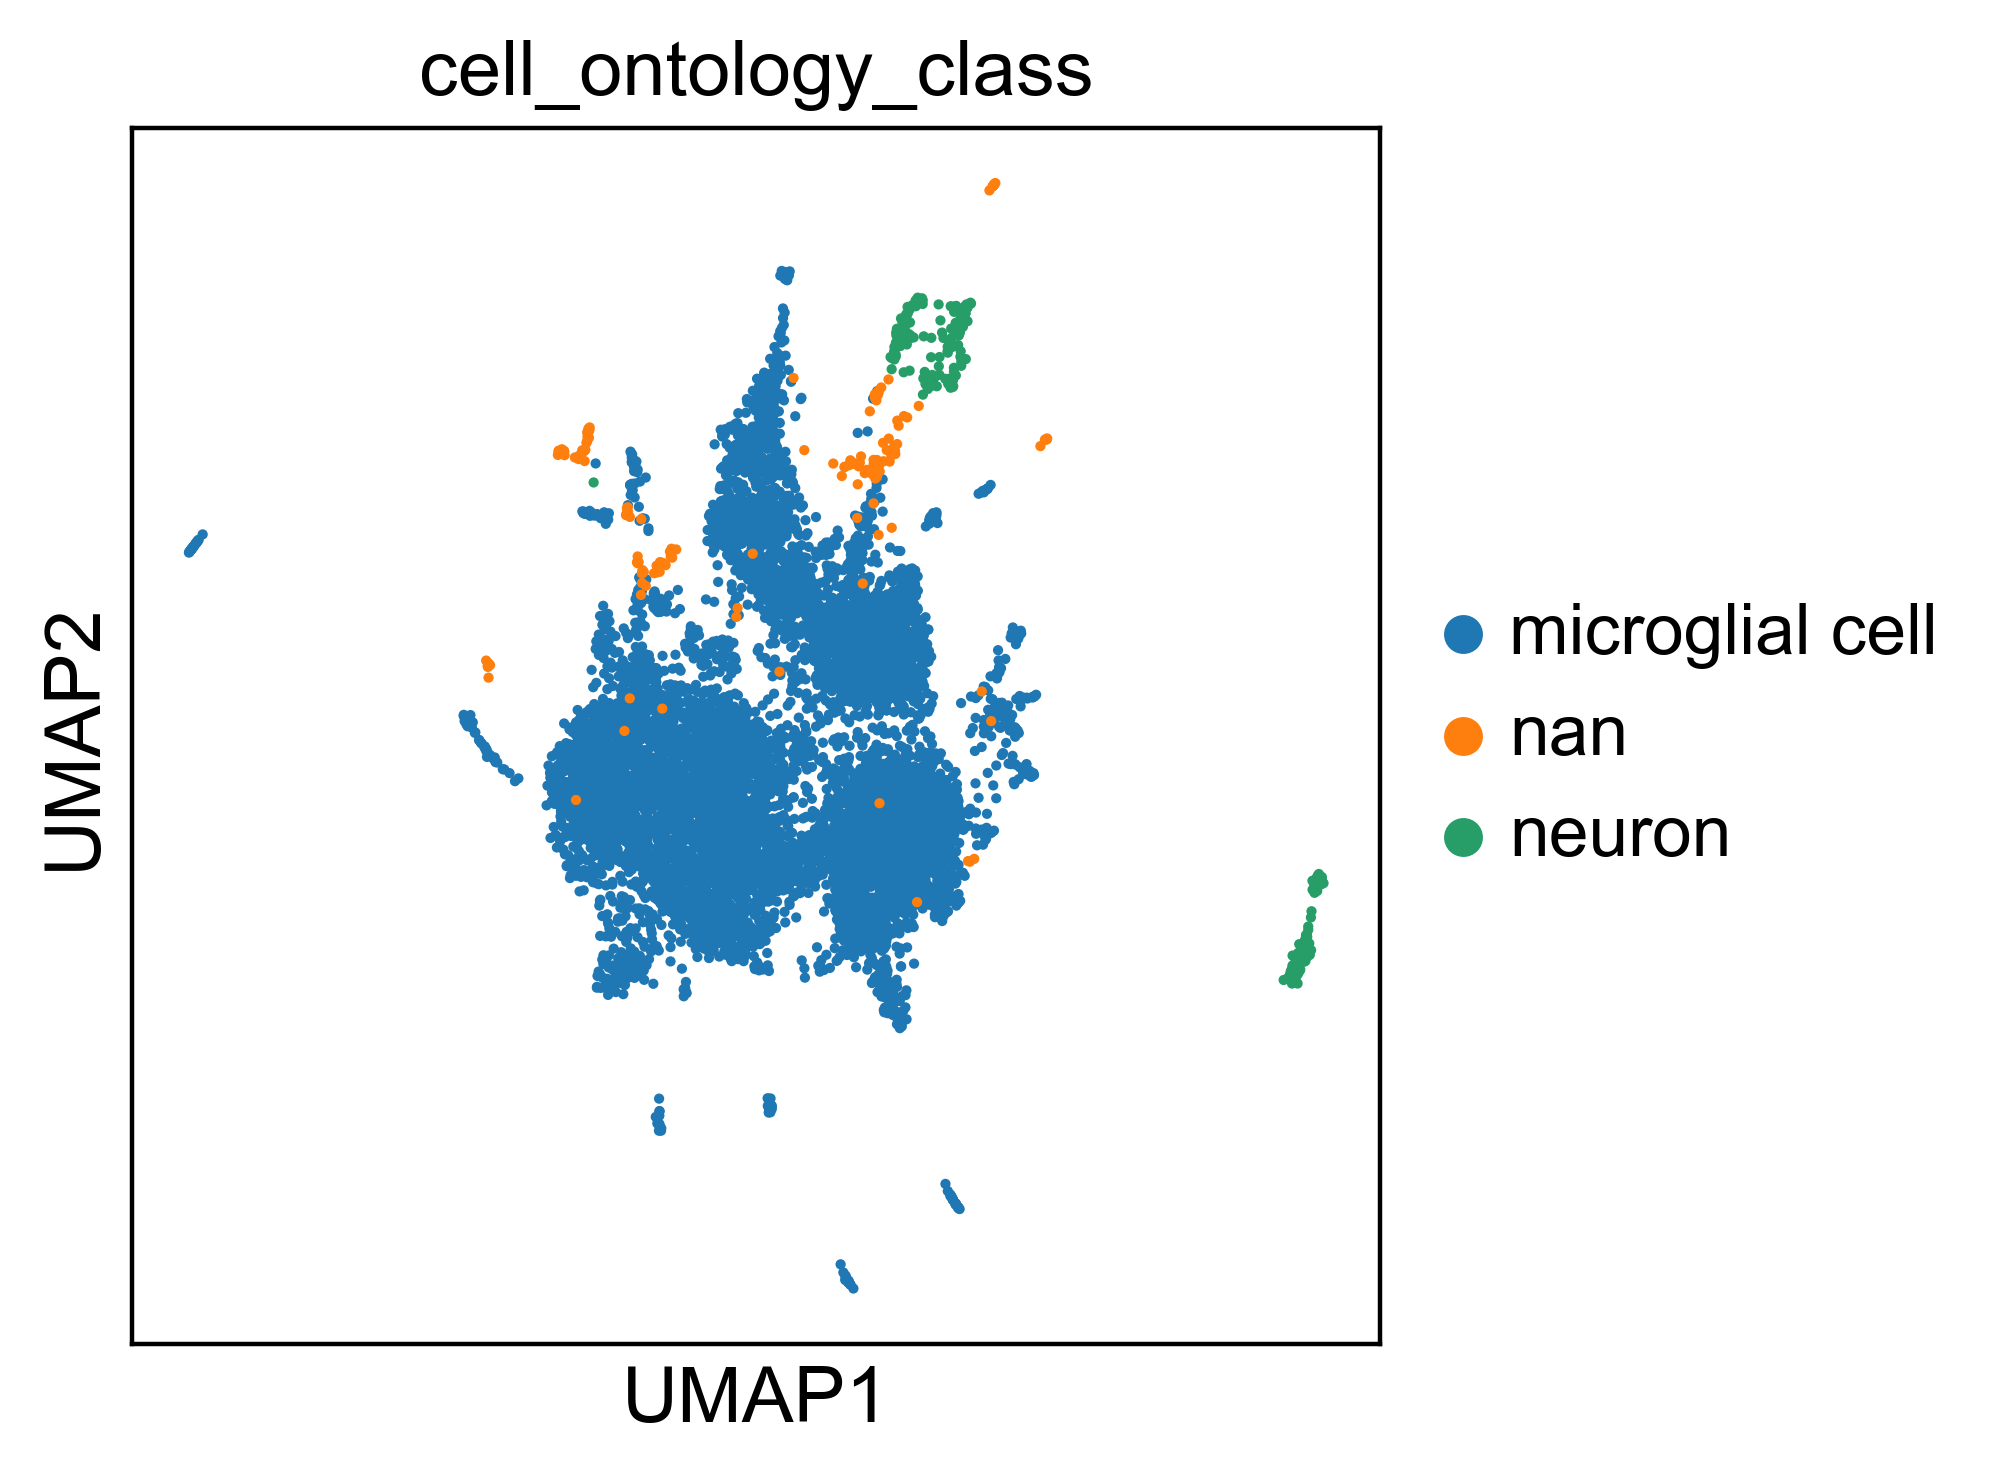

In [19]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['cell_ontology_class'])

In [20]:
pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names)

0          1
index                                                
A10_B000840_S130_L002.mus-0-0-0   4.655431   2.978299
A10_B000843_S94_L001.mus-0-0-0    3.995753   2.661643
A10_B001618_S34_L003.mus-0-0-0    1.169433   4.072673
A10_B003904_S214_L002.mus-0-0-0   2.448279   4.623754
A11_B000843_S95_L001.mus-0-0-0    1.908240   3.367043
...                                    ...        ...
P20.MAA000561.3_10_M.1.1-1-1     11.303499  13.875511
P21.MAA000932.3_11_M.1.1-1-1      8.987643  10.810111
P4.B003728.3_56_F.1.1-1-1         8.590231   8.494558
P6.MAA000947.3_9_M.1.1-1-1        7.020132  11.198059
P8.B000404.3_56_F.1.1-1-1        20.321037   0.636760

[8816 rows x 2 columns]

In [21]:
adata

AnnData object with n_obs × n_vars = 8816 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
np.random.seed(42)

# Group cells by their cluster assignment from 'cell_ontology_class'
clusters = adata.obs['cell_ontology_class'].unique()
age_groups = adata.obs['age'].unique()

# Create a list to store the indices of the randomly selected cells
random_indices = defaultdict(dict)

default_num_neighbors = 100

# Loop through each cluster and select random cells
for cluster in clusters:
    for age in age_groups:
        cluster_indices = adata.obs.index[(adata.obs['cell_ontology_class'] == cluster) & (adata.obs["age"] == age)]
        n_cells = len(cluster_indices)
        print(f"celltype {cluster} at age {age} has {n_cells} number of cells")
        if n_cells < default_num_neighbors * 2 and n_cells != 0:
            n_random_cells_per_cluster = math.floor(n_cells / 10)
            print(f"selected {n_random_cells_per_cluster} for this {cluster} celltype at age {age}")
            selected_indices = np.random.choice(cluster_indices, size=n_random_cells_per_cluster, replace=False)
            random_indices[cluster][age] = selected_indices
        elif n_cells == 0:
            continue
        else:
            n_random_cells_per_cluster = math.floor(n_cells / default_num_neighbors)
            print(f"selected {n_random_cells_per_cluster} for this {cluster} celltype at age {age}")
            selected_indices = np.random.choice(cluster_indices, size=n_random_cells_per_cluster, replace=False)
            random_indices[cluster][age] = selected_indices

celltype microglial cell at age 24m has 3934 number of cells
selected 39 for this microglial cell celltype at age 24m
celltype microglial cell at age 3m has 4486 number of cells
selected 44 for this microglial cell celltype at age 3m
celltype neuron at age 24m has 91 number of cells
selected 9 for this neuron celltype at age 24m
celltype neuron at age 3m has 142 number of cells
selected 14 for this neuron celltype at age 3m
celltype nan at age 24m has 90 number of cells
selected 9 for this nan celltype at age 24m
celltype nan at age 3m has 73 number of cells
selected 7 for this nan celltype at age 3m


In [23]:
if 'X_umap' not in adata.obsm.keys():
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
    sc.tl.umap(adata)

In [24]:
adata

AnnData object with n_obs × n_vars = 8816 × 18774
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
from scipy.spatial import distance_matrix
# Extract the UMAP coordinates
umap_coords = adata.obsm['X_umap']
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP_1', 'UMAP_2'])
umap_df.index = adata.obs.index

# distance_df = pd.DataFrame(adata.obsp["distances"].toarray())
# distance_df.index = adata.obs.index
# distance_df.columns = adata.obs.index

meta_cells_per_celltype = {}
meta_cells_mapping_ages = defaultdict(list)
substring = "m"
gene_names = adata.var_names

neighbors = defaultdict(dict)

for cluster in random_indices:
    print(f"Working on cluster {cluster}...")
    curr_dataframe = pd.DataFrame(columns = gene_names)
    cell_num = 0
    for age in age_groups:
        print(f"{age} group")
        cluster_indices = adata.obs.index[(adata.obs['cell_ontology_class'] == cluster) & (adata.obs["age"] == age)]
        curr_cluster = random_indices[cluster][age]
        selected_coords = umap_df.loc[cluster_indices, :]
        print(f"number of cells {selected_coords.shape}")
        # default Number of nearest neighbors to find
        default_num_neighbors = 100
        age_info = int(age.strip(substring))
        curr_neighbors = {}
        for i, cell in enumerate(curr_cluster):
            print(f"Cell {i} {cell} of {cluster}")
            neighbor_coords = selected_coords.drop(cell).to_numpy()
            if len(neighbor_coords) < default_num_neighbors * 2:
                n_neighbors = 10
                cell_distances = distance_matrix(neighbor_coords, selected_coords.loc[[cell], :]).flatten()
                nearest_indices = np.argsort(cell_distances)[:n_neighbors]
                nearest_real_indices = np.array(cluster_indices)[nearest_indices]
                raw_counts_neighbors = adata[nearest_real_indices, :].X
                
                curr_neighbors[cell] = (adata[nearest_real_indices, :].obs.index)
                
                total_counts = pd.DataFrame(raw_counts_neighbors.sum(axis=0), index = [f"cell {cell_num}"], columns=gene_names)
                curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)
                meta_cells_mapping_ages[cluster].append(age_info)
                cell_num += 1
            else:
                cell_distances = distance_matrix(neighbor_coords, selected_coords.loc[[cell], :]).flatten()
                nearest_indices = np.argsort(cell_distances)[:default_num_neighbors]
                nearest_real_indices = np.array(cluster_indices)[nearest_indices]
                raw_counts_neighbors = adata[nearest_real_indices, :].X
                
                curr_neighbors[cell] = (adata[nearest_real_indices, :].obs.index)
                
                total_counts = pd.DataFrame(raw_counts_neighbors.sum(axis=0), index = [f"cell {cell_num}"], columns=gene_names)
                curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)
                meta_cells_mapping_ages[cluster].append(age_info)
                cell_num += 1
    #         print(total_counts.shape)
        neighbors[cluster][age] = curr_neighbors
    meta_cells_per_celltype[cluster] = curr_dataframe

Working on cluster microglial cell...
24m group
number of cells (3934, 2)
Cell 0 M5_B003921_S293_L001.mus-6-0-0 of microglial cell
Cell 1 G14_B000840_S278_L002.mus-0-0-0 of microglial cell
Cell 2 O10_B003921_S346_L001.mus-6-0-0 of microglial cell
Cell 3 G21_B000840_S285_L002.mus-0-0-0 of microglial cell
Cell 4 E12_B003910_S108.mus-7-0-0 of microglial cell
Cell 5 E8_B003904_S8_L002.mus-0-0-0 of microglial cell
Cell 6 L5_B000843_S53_L001.mus-0-0-0 of microglial cell
Cell 7 I6_B000841_S198_L001.mus-8-0-0 of microglial cell
Cell 8 H12_B003907_S36.mus-7-0-0 of microglial cell
Cell 9 A2_B001217_S230_L004.mus-1-0-0 of microglial cell
Cell 10 D11_B000841_S83_L001.mus-8-0-0 of microglial cell
Cell 11 O6_B001620_S342_L002.mus-8-0-0 of microglial cell
Cell 12 O17_B001217_S281_L004.mus-1-0-0 of microglial cell
Cell 13 O20_B003974_S44_L002.mus-0-0-0 of microglial cell
Cell 14 I1_B000841_S193_L001.mus-8-0-0 of microglial cell
Cell 15 G3_B003914_S207.mus-7-0-0 of microglial cell
Cell 16 H1_B003910_S1

In [26]:
meta_cells_per_celltype["neuron"]

index    0610005C13Rik  0610007C21Rik  0610007L01Rik  0610007N19Rik  \
cell 0        0.000000       5.441917       6.978772       0.000000   
cell 1        0.000000       2.446871       0.000000       0.000000   
cell 2        0.000000       4.403036       3.335649       0.000000   
cell 3        0.000000       2.272667       0.000000       0.000000   
cell 4        0.000000       3.605262       0.000000       0.000000   
cell 5        0.000000       1.912287       1.607604       0.000000   
cell 6        0.000000       7.670328       5.679876       0.000000   
cell 7        0.000000       2.874296       0.000000       0.000000   
cell 8        0.000000       3.926625       5.307177       0.000000   
cell 9        0.000000       8.029466       0.373274       0.000000   
cell 10       0.000000       5.387537       5.270065       0.000000   
cell 11       0.000000       4.428121       1.179546       1.619985   
cell 12       0.000000       3.813400       0.000000       0.000000   
cell 13       0.000000       7.274761       3.172305       8.784303   
cell 14       0.000000       6.872102       1.342170       0.000000   
cell 15       2.887483       9.771673       4.488918       0.000000   
cell 16       0.000000       1.117285       1.709378       0.000000   
cell 17       0.000000       3.908259       7.792903       0.000000   
cell 18       0.000000       3.197030       0.123542       0.000000   
cell 19       0.000000       3.621698       0.323293       0.000000   
cell 20       2.887483       5.941095       1.046059       0.000000   
cell 21       2.887483       5.941095       1.046059       0.000000   
cell 22       0.000000       6.512151       4.247690       8.784303   

index    0610007P08Rik  0610007P14Rik  0610007P22Rik  0610009B22Rik  \
cell 0        1.968851       0.119851       6.652887       2.982154   
cell 1        4.034736       0.000000       3.195448       6.170083   
cell 2        3.716064       3.304652      12.288603       4.232428   
cell 3        1.968851       0.000000       1.522967       0.000000   
cell 4       10.850470       3.027184      10.523916       2.982154   
cell 5        4.007009       6.553761       8.156040       2.332937   
cell 6        6.815734       8.241610       8.709950       5.687505   
cell 7       10.850470       4.650623       2.734092       3.375129   
cell 8        4.534992       2.247949       2.464625       3.707094   
cell 9        4.918354       3.241171       3.193701      13.245122   
cell 10       0.488686       3.234158       7.358226       6.937481   
cell 11       0.488686       9.170583       1.837880       5.046865   
cell 12       3.997663       1.988668      11.600757       5.646117   
cell 13       3.197735       7.445580       6.066360       5.537929   
cell 14       2.128362       5.271679       9.440887       9.900732   
cell 15       3.518500       6.600510      11.020149      11.734322   
cell 16       0.056788       4.245787       2.430990       4.454875   
cell 17       6.402792       7.668393       1.536471       4.010084   
cell 18       0.000000       5.671340       1.800480       6.706821   
cell 19       2.221983       8.331945       1.038201       6.315685   
cell 20       0.000000       3.828011       1.683773       0.959306   
cell 21       0.000000       3.828011       1.683773       0.959306   
cell 22       3.197735       6.021722       4.100019       6.074954   

index    0610009D07Rik  0610009L18Rik  ...      Zwint       Zxda       Zxdb  \
cell 0        2.310136       0.000000  ...  11.338465   0.000000   5.651509   
cell 1        1.516841       0.000000  ...  14.988286   0.000000   0.000000   
cell 2        4.367236       8.466727  ...  14.426271   0.000000   5.651509   
cell 3        0.000000       0.000000  ...   6.820953   0.000000   0.000000   
cell 4        2.997633       0.000000  ...   7.788664   0.000000   0.000000   
cell 5        5.543823       4.821091  ...  12.528773   0.000000   0.000000   
cell 6        8.446043       3.449914

In [27]:
meta_cells_per_celltype["microglial cell"]

index    0610005C13Rik  0610007C21Rik  0610007L01Rik  0610007N19Rik  \
cell 0        0.000000     116.000557      34.806484            0.0   
cell 1        9.828265     114.087837      40.996872            0.0   
cell 2        0.000000     113.255569      48.218395            0.0   
cell 3        0.000000     119.037926      35.872547           10.0   
cell 4        0.000000     113.743004      34.494484           10.0   
...                ...            ...            ...            ...   
cell 78      20.000000     103.956642      63.197182            0.0   
cell 79      20.000000     125.636108      38.404690           10.0   
cell 80       0.000000     109.297348      58.356693           10.0   
cell 81      20.000000     120.777786      32.801865           10.0   
cell 82      20.000000     103.616905      45.299595           10.0   

index    0610007P08Rik  0610007P14Rik  0610007P22Rik  0610009B22Rik  \
cell 0        9.302948      37.337635      19.975294      59.125237   
cell 1        5.642536      31.126190      22.281166      26.512701   
cell 2       10.517851      44.952003      10.477765      39.124657   
cell 3       10.832275      27.511175      41.342155      28.847439   
cell 4       25.174595      36.423008      38.633663      37.582207   
...                ...            ...            ...            ...   
cell 78      18.873402      22.776739      16.665295      36.883007   
cell 79      17.660288      39.707176      50.561993      28.023834   
cell 80      20.778225      61.618999      19.846245      62.746548   
cell 81      36.729900      26.171204      28.036684      44.434010   
cell 82      23.133028      44.904781      48.570301      32.745399   

index    0610009D07Rik  0610009L18Rik  ...      Zwint       Zxda       Zxdb  \
cell 0       40.294350      40.347904  ...  60.376297  25.221680  17.891899   
cell 1       53.234165      32.245060  ...  34.796066  12.000800   7.259944   
cell 2       49.687832      15.249060  ...  14.790177  12.270992   0.000000   
cell 3       30.933889      18.279289  ...  45.570667   0.000000   6.644098   
cell 4       45.640709      18.511543  ...  41.841084   6.385339  20.864227   
...                ...            ...  ...        ...        ...        ...   
cell 78      65.763824      19.704750  ...  27.599916  27.077217  24.564852   
cell 79      59.682201       5.128454  ...  24.810213  11.029486  25.041752   
cell 80      48.830112      50.153904  ...  37.057442  21.578985   6.941597   
cell 81      77.734123      21.787233  ...  45.102760  32.854073  39.450203   
cell 82      60.464279      15.482872  ...  33.038425  28.034763  13.593874   

index         Zxdc  Zyg11a     Zyg11b        Zyx      Zzef1       Zzz3  \
cell 0    8.046879     0.0  53.123577  83.523109  54.869926  33.690037   
cell 1   18.667004     0.0  42.563305  47.029919  45.093712  47.907284   
cell 2   45.366623     0.0  26.063532  63.484962  33.727173  34.365753   
cell 3   39.410667     0.0  30.654009  59.934063  33.896355  27.445438   
cell 4   24.707035     0.0  50.718620  61.026520  69.626053  30.559320   
...            ...     ...        ...        ...        ...        ...   
cell 78  32.371494     0.0  60.943100  69.645378  39.914993  42.588890   
cell 79  39.786655     0.0  67.741158  83.200699  39.064541  58.684319   
cell 80  34.129189     0.0  48.267250  41.382420  17.352146  34.209702   
cell 81  29.341724     0.0  58.135376  58.103954  51.935528  56.005402   
cell 82  36.624123     0.0  70.932182  73.404510  53.177944  56.299896   

index        l7Rn6  
cell 0   13.483858  
cell 1   17.348867  
cell 2   23.651707  
cell 3    8.285251  
cell 4   24.013144  
...            ...  
cell 78  34.905590  
cell 79  26.251404  
cell 80  34.339737  
cell 81  61.584999  
cell 82  50.422577  

[83 rows x 18774 columns]

In [28]:
test = adata.copy()
if 'test_neighbors' not in test.obs:
    test.obs['test_neighbors'] = pd.NA 

In [29]:
test.obs['test_neighbors'] = test.obs['test_neighbors'].astype('object')

In [30]:
test.obs.loc['K3_D045315_B008285_S243.mm10-plus-3-0-0', 'test_neighbors'] = "selected_cell_1"
test.obs.loc['F7_B002518_B009295_S187.mm10-plus-1-0-0', 'test_neighbors'] = "selected_cell_2"

In [31]:
test_cell_1 = neighbors["microglial cell"]["18m"]['K3_D045315_B008285_S243.mm10-plus-3-0-0']
test_cell_2 = neighbors["microglial cell"]["18m"]['F7_B002518_B009295_S187.mm10-plus-1-0-0']

KeyError: '18m'

In [ ]:
test.obs.loc[test_cell_1, 'test_neighbors'] = "neighbor_cells_1"
test.obs.loc[test_cell_2, 'test_neighbors'] = "neighbor_cells_2"

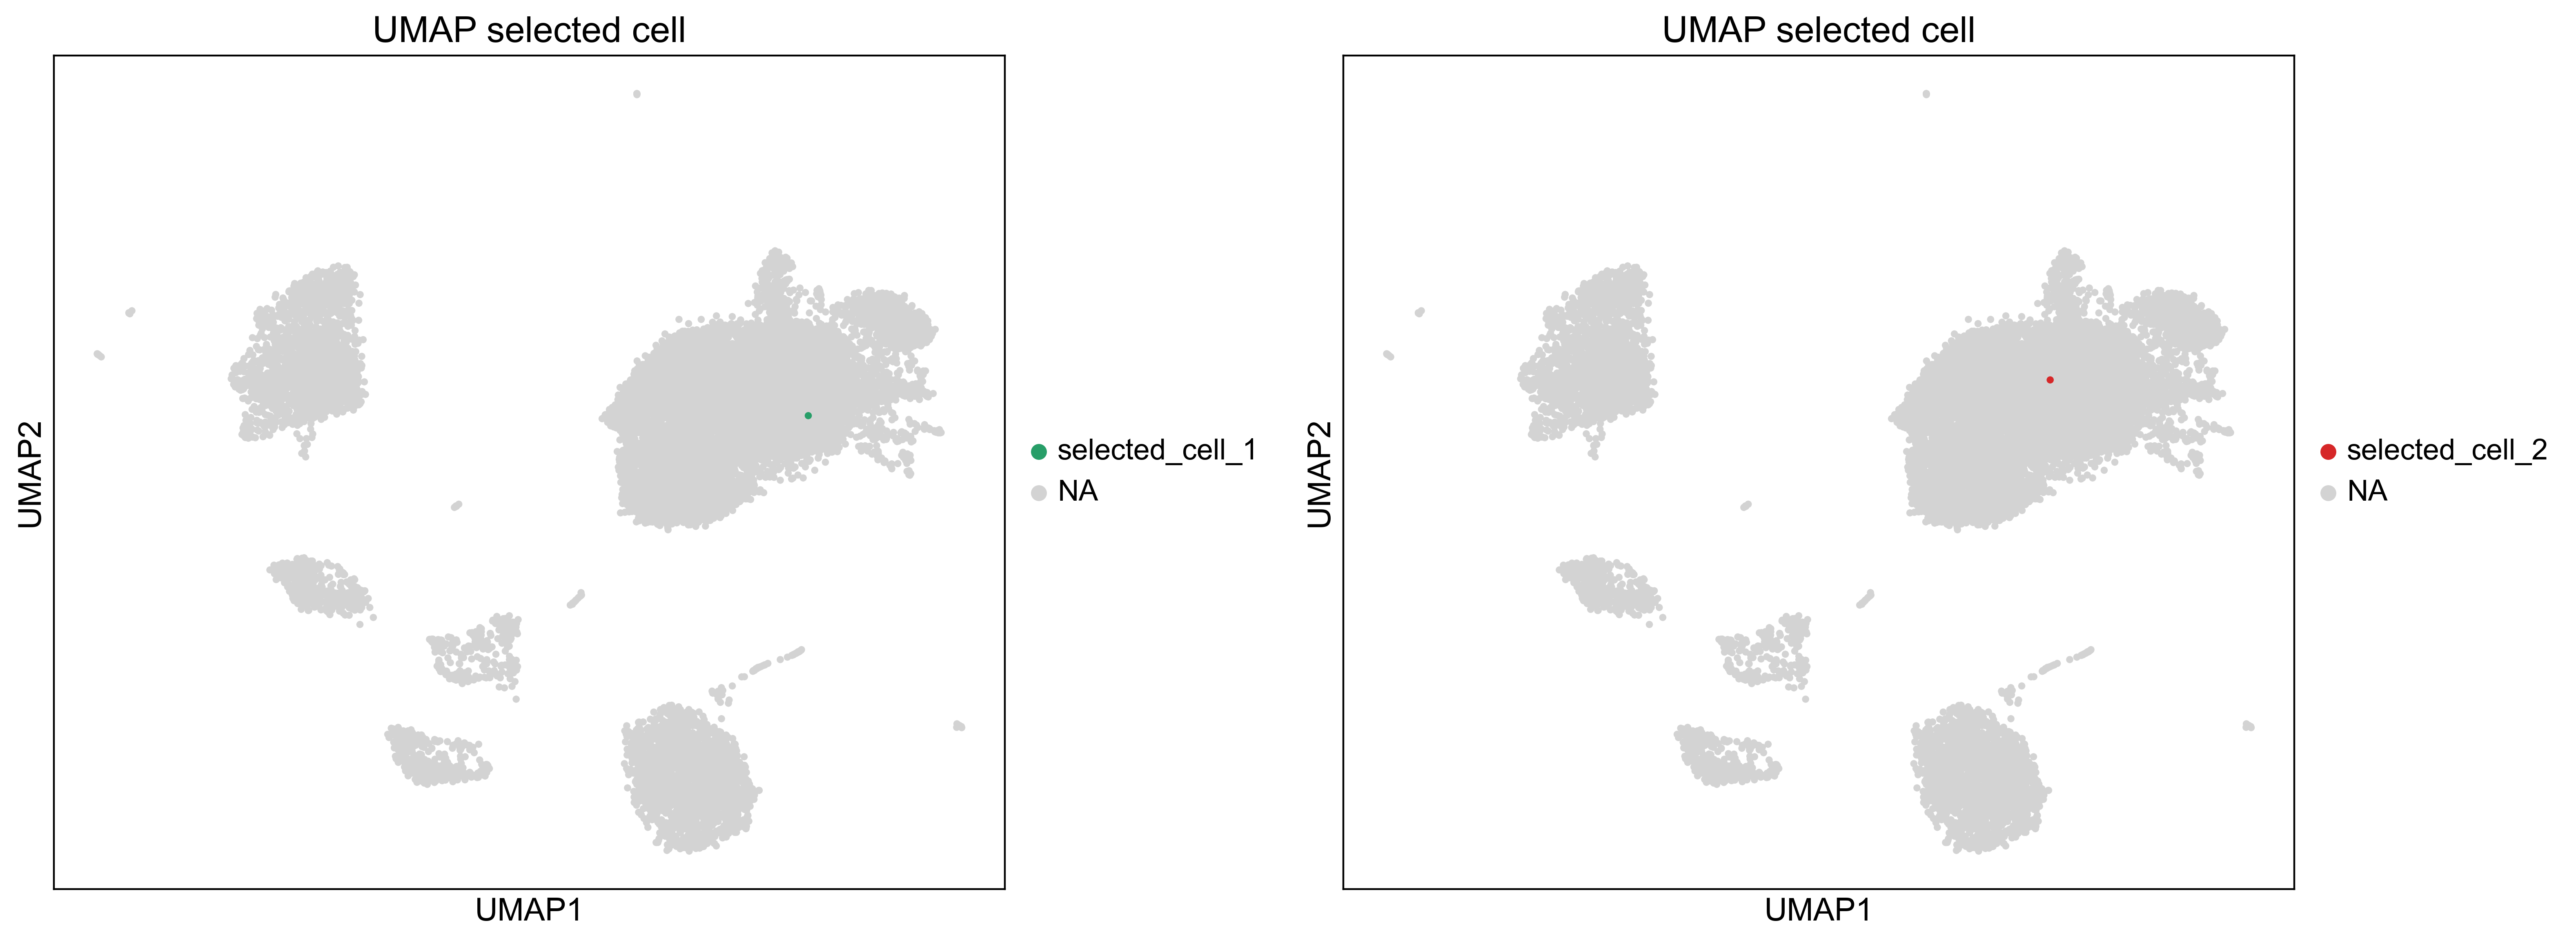

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs = axs.flatten()
with plt.rc_context(font_size_config):
    sc.pl.umap(test, color="test_neighbors", ax=axs[0], groups=["selected_cell_1"], size=40, show=False, title='UMAP selected cell')
    sc.pl.umap(test, color="test_neighbors", ax=axs[1], groups=["selected_cell_2"], size=40, show=False, title='UMAP selected cell')

plt.tight_layout()
plt.show()

In [ ]:
print(test.obs['test_neighbors'].value_counts())

neighbor_cells_1    100
neighbor_cells_2    100
selected_cell_1       1
selected_cell_2       1
Name: test_neighbors, dtype: int64


<Axes: title={'center': 'UMAP selected cell'}, xlabel='UMAP1', ylabel='UMAP2'>

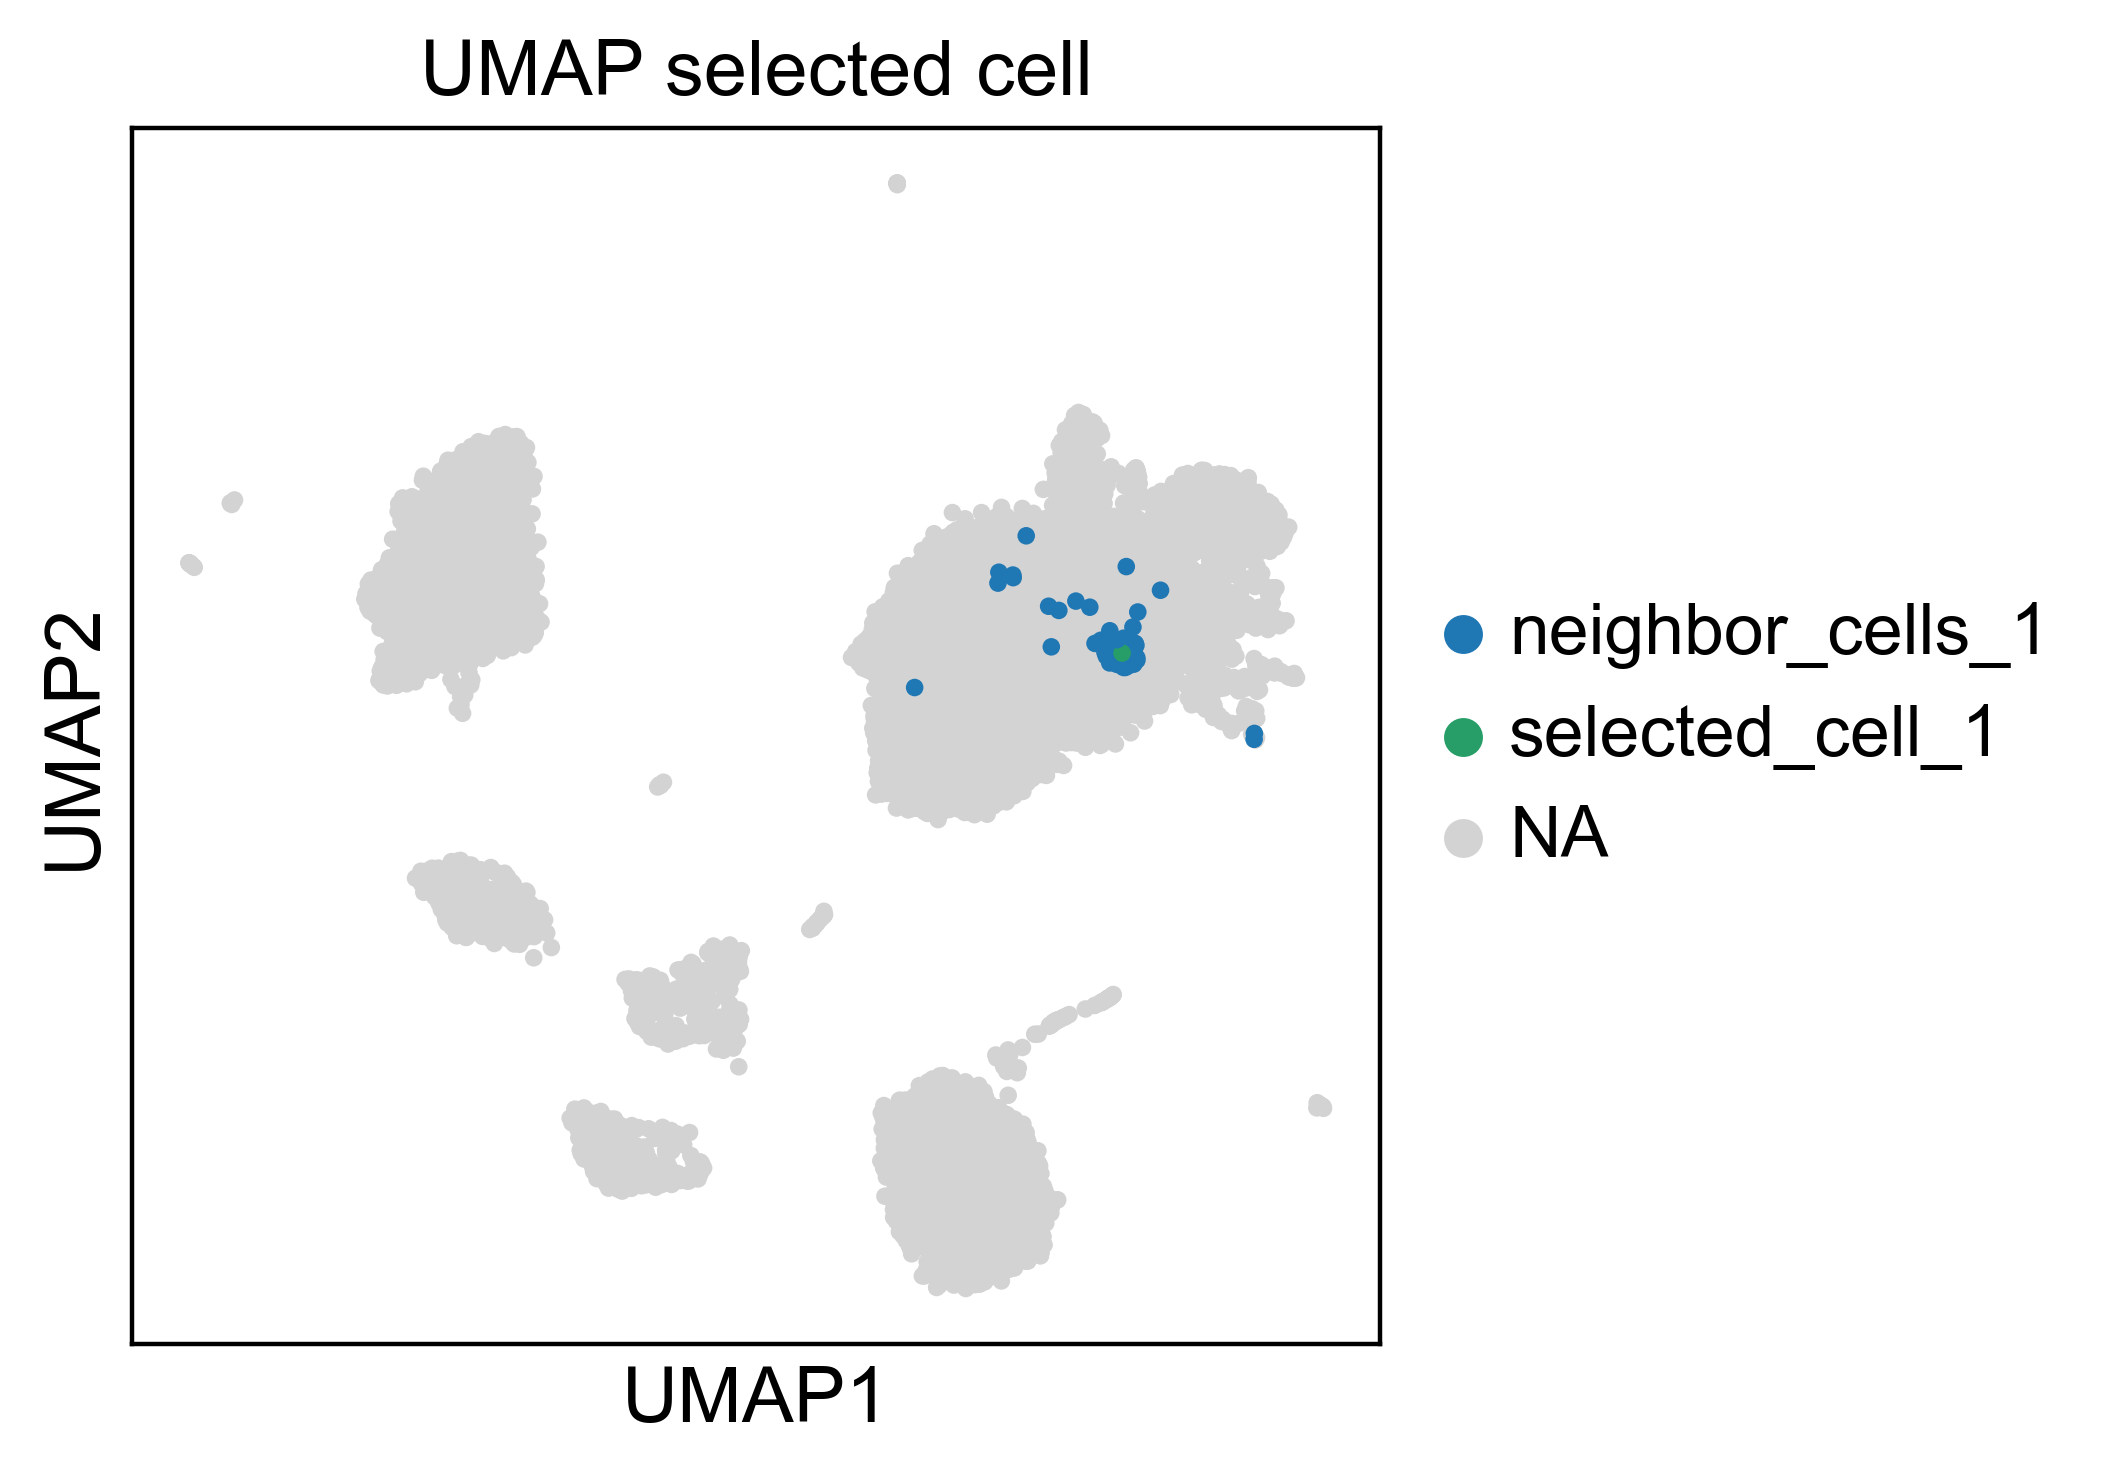

In [ ]:
sc.pl.umap(test, color="test_neighbors", groups=["neighbor_cells_1", "selected_cell_1"], size=40, 
           show=False, title='UMAP selected cell')

<Axes: title={'center': 'UMAP selected cell'}, xlabel='UMAP1', ylabel='UMAP2'>

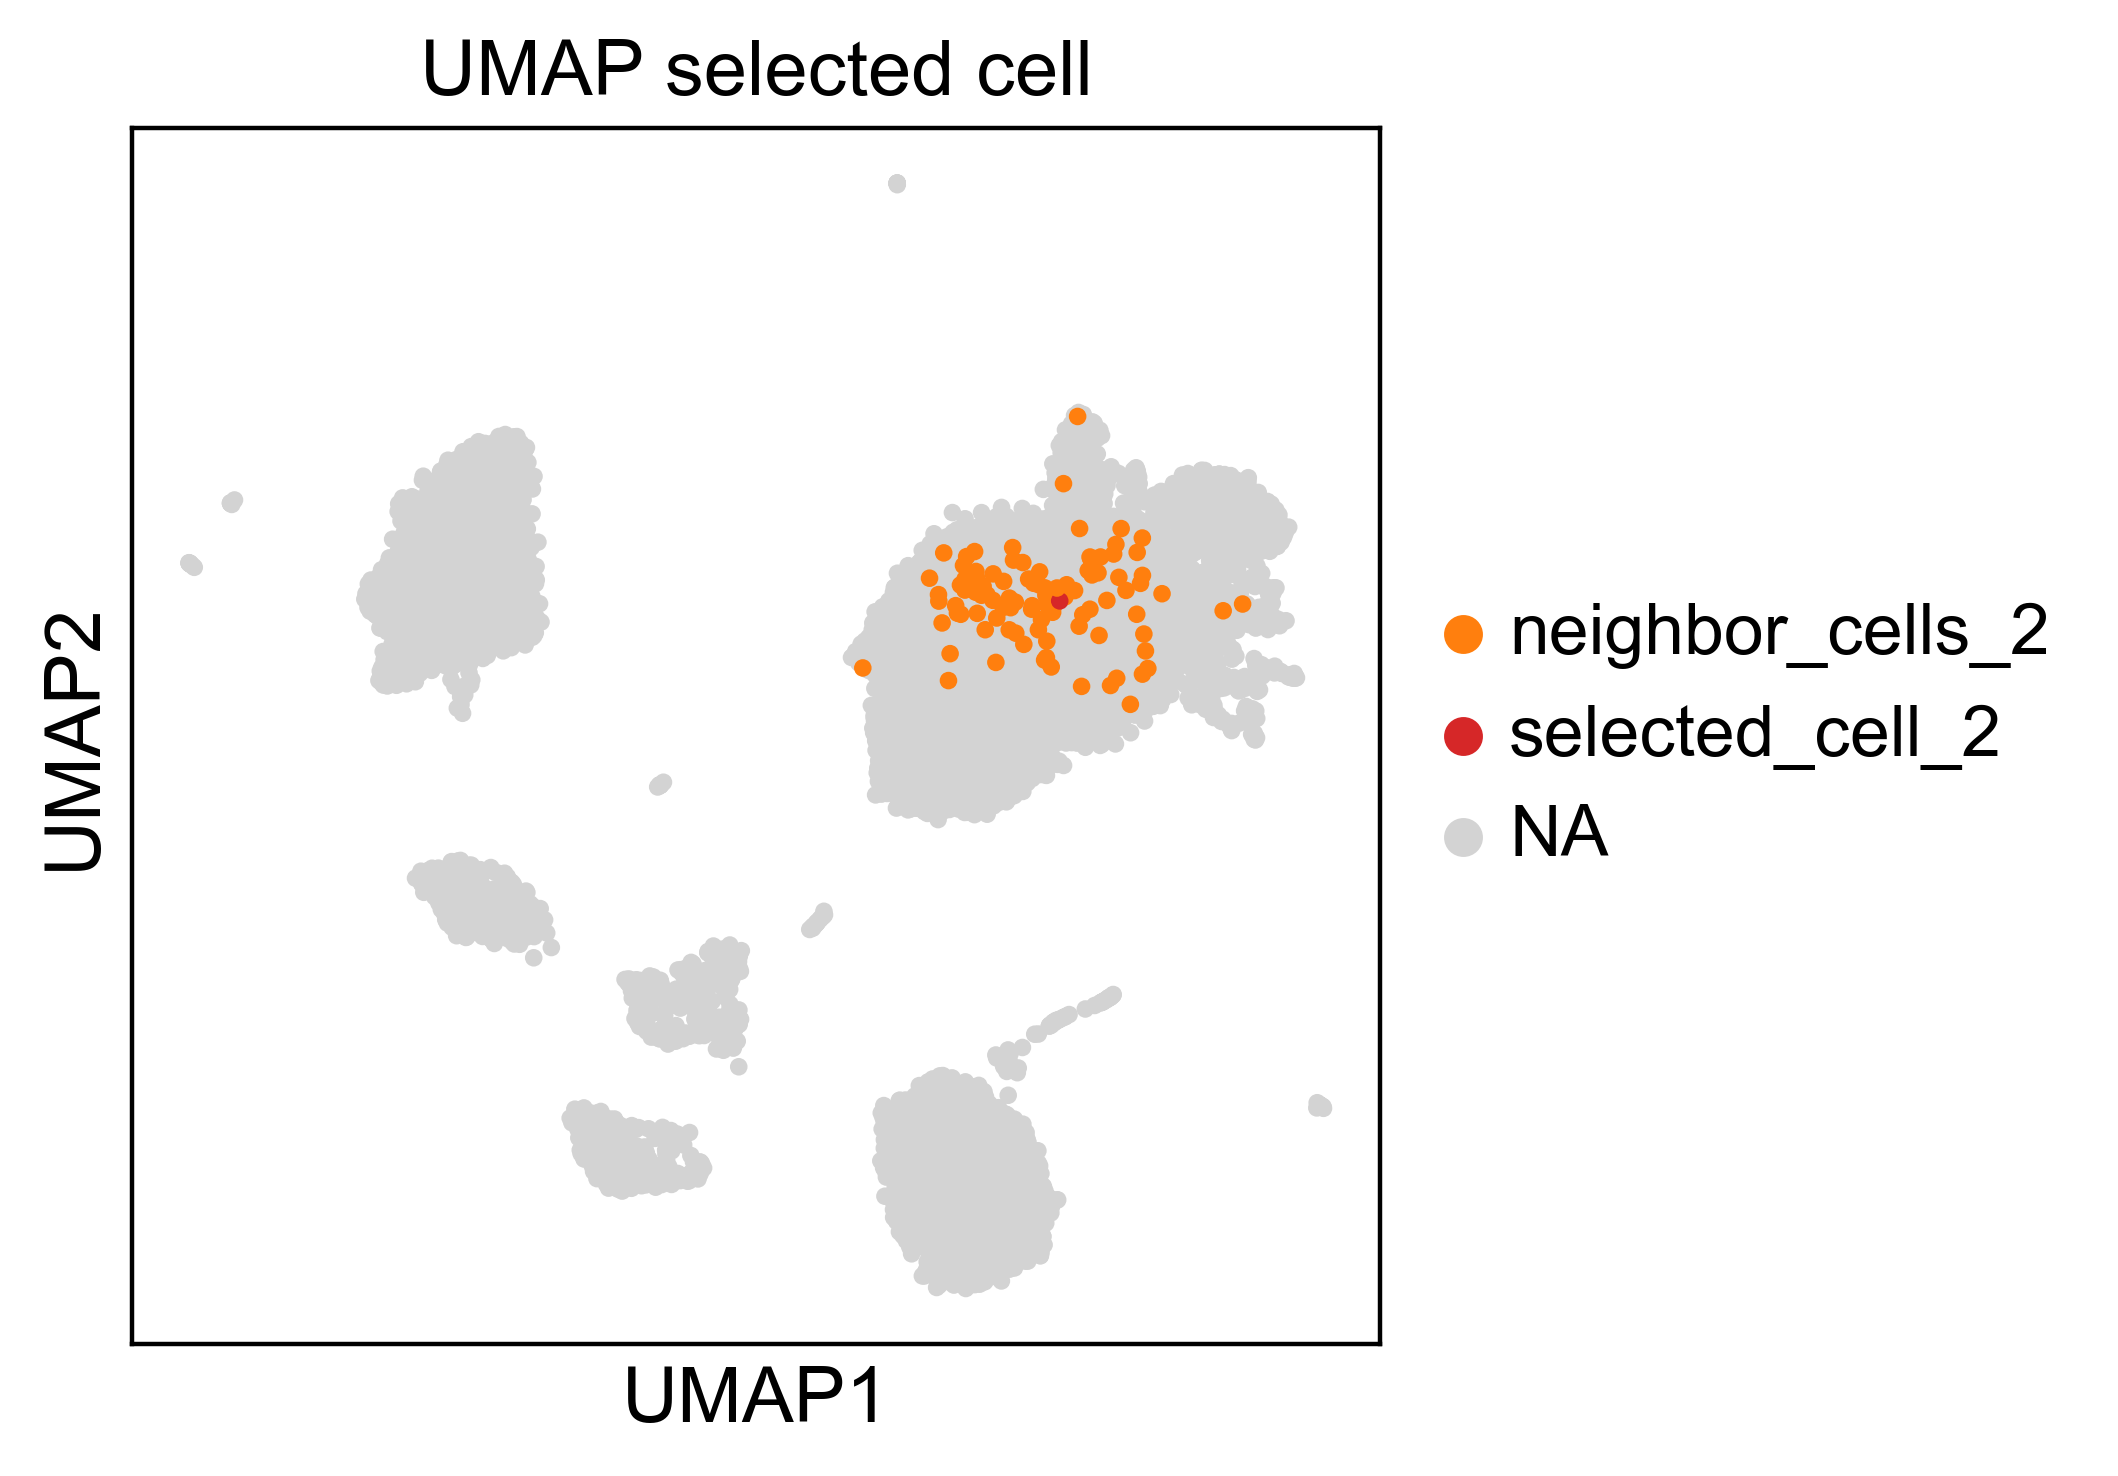

In [ ]:
sc.pl.umap(test, color="test_neighbors", 
           groups=["neighbor_cells_2", "selected_cell_2"], size=40, show=False, title='UMAP selected cell')

## Start working on the gene correlation

In [2]:
celltype_df = pd.DataFrame(adata.obs["cell_ontology_class"])
celltype_df = celltype_df.rename(columns={"cell_ontology_class": "celltype"})
age_df = pd.DataFrame(adata.obs["age"])
age_df = age_df.rename(columns={"age": "age"})

NameError: name 'pd' is not defined

In [ ]:
def clean_age(age_df, substring):
    values = []
    for x in age_df["age"]:
        try:
            # Attempt to strip the substring and convert to integer
            value = int(x.strip(substring))
            values.append(value)
        except ValueError:
            # Handle the case where conversion fails
            warnings.warn(f"Warning: '{x}' could not be converted to an integer.")
            break
    age_df["age"] = values
    return age_df

In [ ]:
cleaned_age_df = clean_age(age_df, "m")

In [ ]:
def get_raw_counts(adata, celltype_df):
    raw_count = pd.DataFrame.sparse.from_spmatrix(adata.X.T, 
                                               index = adata.var_names, 
                                               columns = adata.obs_names).astype(int)
    raw_count = raw_count[list(celltype_df.index)]
    return raw_count

In [ ]:
adata.obsp["distances"]

<15692x15692 sparse matrix of type '<class 'numpy.float32'>'
	with 298148 stored elements in Compressed Sparse Row format>

In [ ]:
adata

AnnData object with n_obs × n_vars = 15692 × 21026
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'batch'
    var: 'n_cells', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-1', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.obs

FACS.selection  age  \
index                                                          
A10_B001060_B009250_S214.mm10-plus-1-0-0      Microglia  18m   
A10_B001061_B009251_S298.mm10-plus-1-0-0      Microglia  18m   
A10_B002702_B009296_S154.mm10-plus-1-0-0      Microglia  18m   
A11_B001060_B009250_S215.mm10-plus-1-0-0      Microglia  18m   
A11_B001061_B009251_S299.mm10-plus-1-0-0      Microglia  18m   
...                                                 ...  ...   
P9.MAA000564.3_10_M.1.1-1-1-1                       nan   3m   
P9.MAA000930.3_8_M.1.1-1-1-1                        nan   3m   
P9.MAA000932.3_11_M.1.1-1-1-1                       nan   3m   
P9.MAA000935.3_8_M.1.1-1-1-1                        nan   3m   
P9.MAA001894.3_39_F.1.1-1-1-1                       nan   3m   

                                                             cell  \
index                                                               
A10_B001060_B009250_S214.mm10-plus-1-0-0              A10_B001060   
A10_B001061_B009251_S298.mm10-plus-1-0-0              A10_B001061   
A10_B002702_B009296_S154.mm10-plus-1-0-0              A10_B002702   
A11_B001060_B009250_S215.mm10-plus-1-0-0              A11_B001060   
A11_B001061_B009251_S299.mm10-plus-1-0-0              A11_B001061   
...                                                           ...   
P9.MAA000564.3_10_M.1.1-1-1-1             P9.MAA000564.3_10_M.1.1   
P9.MAA000930.3_8_M.1.1-1-1-1               P9.MAA000930.3_8_M.1.1   
P9.MAA000932.3_11_M.1.1-1-1-1             P9.MAA000932.3_11_M.1.1   
P9.MAA000935.3_8_M.1.1-1-1-1               P9.MAA000935.3_8_M.1.1   
P9.MAA001894.3_39_F.1.1-1-1-1             P9.MAA001894.3_39_F.1.1   

                                         cell_ontology_class cell_ontology_id  \
index                                                                           
A10_B001060_B009250_S214.mm10-plus-1-0-0     microglial cell              nan   
A10_B001061_B009251_S298.mm10-plus-1-0-0     microglial cell              nan   
A10_B002702_B009296_S154.mm10-plus-1-0-0     microglial cell              nan   
A11_B001060_B009250_S215.mm10-plus-1-0-0     microglial cell              nan   
A11_B001061_B009251_S299.mm10-plus-1-0-0     microglial cell              nan   
...                                                      ...              ...   
P9.MAA000564.3_10_M.1.1-1-1-1                oligodendrocyte       CL:0000128   
P9.MAA000930.3_8_M.1.1-1-1-1                       astrocyte       CL:0000127   
P9.MAA000932.3_11_M.1.1-1-1-1               endothelial cell       CL:0000115   
P9.MAA000935.3_8_M.1.1-1-1-1                 oligodendrocyte       CL:0000128   
P9.MAA001894.3_39_F.1.1-1-1-1                      astrocyte       CL:0000127   

                                           free_annotation method mouse.id  \
index                                                                        
A10_B001060_B009250_S214.mm10-plus-1-0-0               nan   facs  18_47_F   
A10_B001061_B009251_S298.mm10-plus-1-0-0               nan   facs  18_46_F   
A10_B002702_B009296_S154.mm10-plus-1-0-0               nan   facs  18_53_M   
A11_B001060_B009250_S215.mm10-plus-1-0-0               nan   facs  18_47_F   
A11_B001061_B009251_S299.mm10-plus-1-0-0               nan   facs  18_46_F   
...                                                    ...    ...      ...   
P9.MAA000564.3_10_M.1.1-1-1-1                          nan   facs   3_10_M   
P9.MAA000930.3_8_M.1.1-1-1-1                           nan   facs    3_8_M   
P9.MAA000932.3_11_M.1.1-1-1-1             Endothelial cell   facs   3_11_M   
P9.MAA000935.3_8_M.1.1-1-1-1                           nan   facs    3_8_M   
P9.MAA001894.3_39_F.1.1-1-1-1                          nan   facs   3_39_F   

                                             sex    subtissue  \
index                                                           
A10_B001060_B009250_S214.mm10-plus-1-0-0  female  Cerebellum    
A10_B001061_B009251_S298.mm10-plus-1-0-0  fema

In [ ]:
raw_count = get_raw_counts(adata, celltype_df)

/var/folders/mv/_qscsgmx42x_pq8pt91ff5780000gn/T/ipykernel_24920/1872111541.py:4: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  columns = adata.obs_names).astype(int)


In [ ]:
raw_count

index          A10_B001060_B009250_S214.mm10-plus-1-0-0  \
index                                                     
0610005C13Rik                                         0   
0610007C21Rik                                         2   
0610007L01Rik                                         0   
0610007N19Rik                                         0   
0610007P08Rik                                         0   
...                                                 ...   
Zyg11a                                                0   
Zyg11b                                                0   
Zyx                                                   0   
Zzef1                                                 0   
Zzz3                                                  0   

index          A10_B001061_B009251_S298.mm10-plus-1-0-0  \
index                                                     
0610005C13Rik                                         0   
0610007C21Rik                                         0   
0610007L01Rik                                         0   
0610007N19Rik                                         0   
0610007P08Rik                                         0   
...                                                 ...   
Zyg11a                                                0   
Zyg11b                                                1   
Zyx                                                   1   
Zzef1                                                 0   
Zzz3                                                  0   

index          A10_B002702_B009296_S154.mm10-plus-1-0-0  \
index                                                     
0610005C13Rik                                         0   
0610007C21Rik                                         0   
0610007L01Rik                                         0   
0610007N19Rik                                         0   
0610007P08Rik                                         0   
...                                                 ...   
Zyg11a                                                0   
Zyg11b                                                0   
Zyx                                                   0   
Zzef1                                                 0   
Zzz3                                                  0   

index          A11_B001060_B009250_S215.mm10-plus-1-0-0  \
index                                                     
0610005C13Rik                                         0   
0610007C21Rik                                         2   
0610007L01Rik                                         0   
0610007N19Rik                                         0   
0610007P08Rik                                         0   
...                                                 ...   
Zyg11a                                                0   
Zyg11b                                                3   
Zyx                                                   0   
Zzef1                                                 0   
Zzz3                                                  0   

index          A11_B001061_B009251_S299.mm10-plus-1-0-0  \
index                                                     
0610005C13Rik                                         0   
0610007C21Rik                                         0   
0610007L01Rik                                         0   
0610007N19Rik                                         0   
0610007P08Rik                                         0   
...                                                 ...   
Zyg11a                                                0   
Zyg11b                                                0   
Zyx                                                   0   
Zzef1                                                 0   
Zzz3                                                  0   

index          A11_B002518_B009295_S71.mm10-plus-1-0-0  \
index                                                    
0610005C13Rik                               

In [ ]:
### testing
raw_count.shape[1] == celltype_df.shape[0]

True

In [ ]:
gene_names = np.array(raw_count.index)
celltype_dict = {}
for celltype in Counter(celltype_df["celltype"]):
    celltype_dict[celltype] = list(adata.obs[adata.obs["cell_ontology_class"] == celltype].index)
age_groups = np.unique(cleaned_age_df["age"])

In [ ]:
### looking for genes that are highly expressed and filter out all the low-count ones
from Helper.Load_matrix import get_normalized_matrix
threshold = 0.50
selected_gene_by_frac = dict()
for celltype in tqdm(celltype_df["celltype"].unique()):
    current_cells = raw_count[celltype_dict[celltype]] 
    norm_curr_cells = get_normalized_matrix(current_cells)
    
    mean_percent = norm_curr_cells.mean(axis=0)
    argsort_index = np.argsort(mean_percent).values
    counts_top_genes = norm_curr_cells.iloc[:, argsort_index]
    
    # Adjust selection to get top-expressing genes
    top_genes = list(counts_top_genes.columns)[-int(counts_top_genes.shape[1] * threshold):]
    selected_gene_by_frac[celltype] = top_genes

  0%|                                                   | 0/6 [00:00<?, ?it/s]/Users/chanyue/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
 17%|███████▏                                   | 1/6 [00:02<00:11,  2.37s/it]/Users/chanyue/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
 33%|██████████████▎                            | 2/6 [00:02<00:04,  1.17s/it]/Users/chanyue/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/chanyue/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
 67%|█

In [ ]:
import os
cor_info_path = "HiExpr_correlation_info_matrix/Tabula_Muris_Brain"

In [ ]:
if not os.path.exists(cor_info_path):
    os.makedirs(cor_info_path)
    print("Correlation output directory created successfully.")
else:
    print("Correlation output directory already exists.")

Correlation output directory already exists.


In [ ]:
correlated_genes = {}
correlations = {}
if not os.path.exists(cor_info_path):
    os.makedirs(cor_info_path)

for celltype in meta_cells_per_celltype:
    print(f"Processing cell type {celltype}...")
    curr_cells = meta_cells_per_celltype[celltype]  # Access the metacell dataframe for each cell type
    curr_genes = selected_gene_by_frac[celltype]  # Get the selected gene list for the current cell type
    curr_ages = meta_cells_mapping_ages[celltype]
    

    curr_corrs = []
    abs_curr_corrs = []

    for gene in curr_genes:
        gene_exprs = curr_cells[gene].values  # Get gene expression for the selected gene from the metacell dataframe
        r, p_value = stats.pearsonr(gene_exprs, curr_ages)
        curr_corrs.append(r)
        abs_curr_corrs.append(abs(r))
               
    # sort the correlations
    curr_corrs = np.nan_to_num(curr_corrs)
    
    abs_curr_corrs = np.nan_to_num(abs_curr_corrs)
    order = np.argsort(abs_curr_corrs)
    sorted_corrs = abs_curr_corrs[order][::-1]
    sorted_genes = np.array(curr_genes)[order][::-1]

    # store values 
    correlations[celltype] = sorted_corrs
    correlated_genes[celltype] = list(sorted_genes)

    # Save to CSV
    file = pd.DataFrame(curr_corrs, index=np.array(curr_genes), columns=["Pearson Correlation"])
    file_path = os.path.join(cor_info_path, f"no_absolute_{celltype}_correlations.csv")
    file.to_csv(file_path)

/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing cell type microglial cell...
Processing cell type oligodendrocyte...


/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing cell type astrocyte...


/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing cell type brain pericyte...


/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing cell type endothelial cell...


/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing cell type neuron...


/Users/chanyue/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Compute the frequency for training

In [ ]:
train_age_groups = {}
### pred_freqs are the fitted frequencies from linearRegression
pred_freq_matrices = {}
freq_matrices = {}
for celltype in meta_cells_per_celltype:
    df = pd.DataFrame(meta_cells_per_celltype[celltype])[correlated_genes[celltype]]
    df.index = meta_cells_mapping_ages[celltype]
    frequency_matrix = df.div(np.sum(df, axis = 1), axis = 0)
    frequency_matrix = frequency_matrix.fillna(0)
    freq_matrices[celltype] = frequency_matrix.T
    
    pred_freqs = np.zeros((frequency_matrix.shape))
    pred_freqs = pd.DataFrame(pred_freqs, columns=frequency_matrix.columns)
    train_age = np.array(meta_cells_mapping_ages[celltype]).reshape(-1,1)
    train_age_groups[celltype] = train_age
    for gene in frequency_matrix:
        reg = LinearRegression(n_jobs=1).fit(train_age, np.array(frequency_matrix[gene]))
        predictions = reg.predict(train_age)
        pred_freqs[gene] = predictions
    pred_freqs[pred_freqs < 0] = 1e-6
    pred_freqs.index = frequency_matrix.index
    pred_freqs = pred_freqs.groupby(pred_freqs.index).mean()
    pred_freqs = pred_freqs.T
    pred_freq_matrices[celltype] = pred_freqs

## Testing 
### plotting the metacell counts

104


100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 823.08it/s]


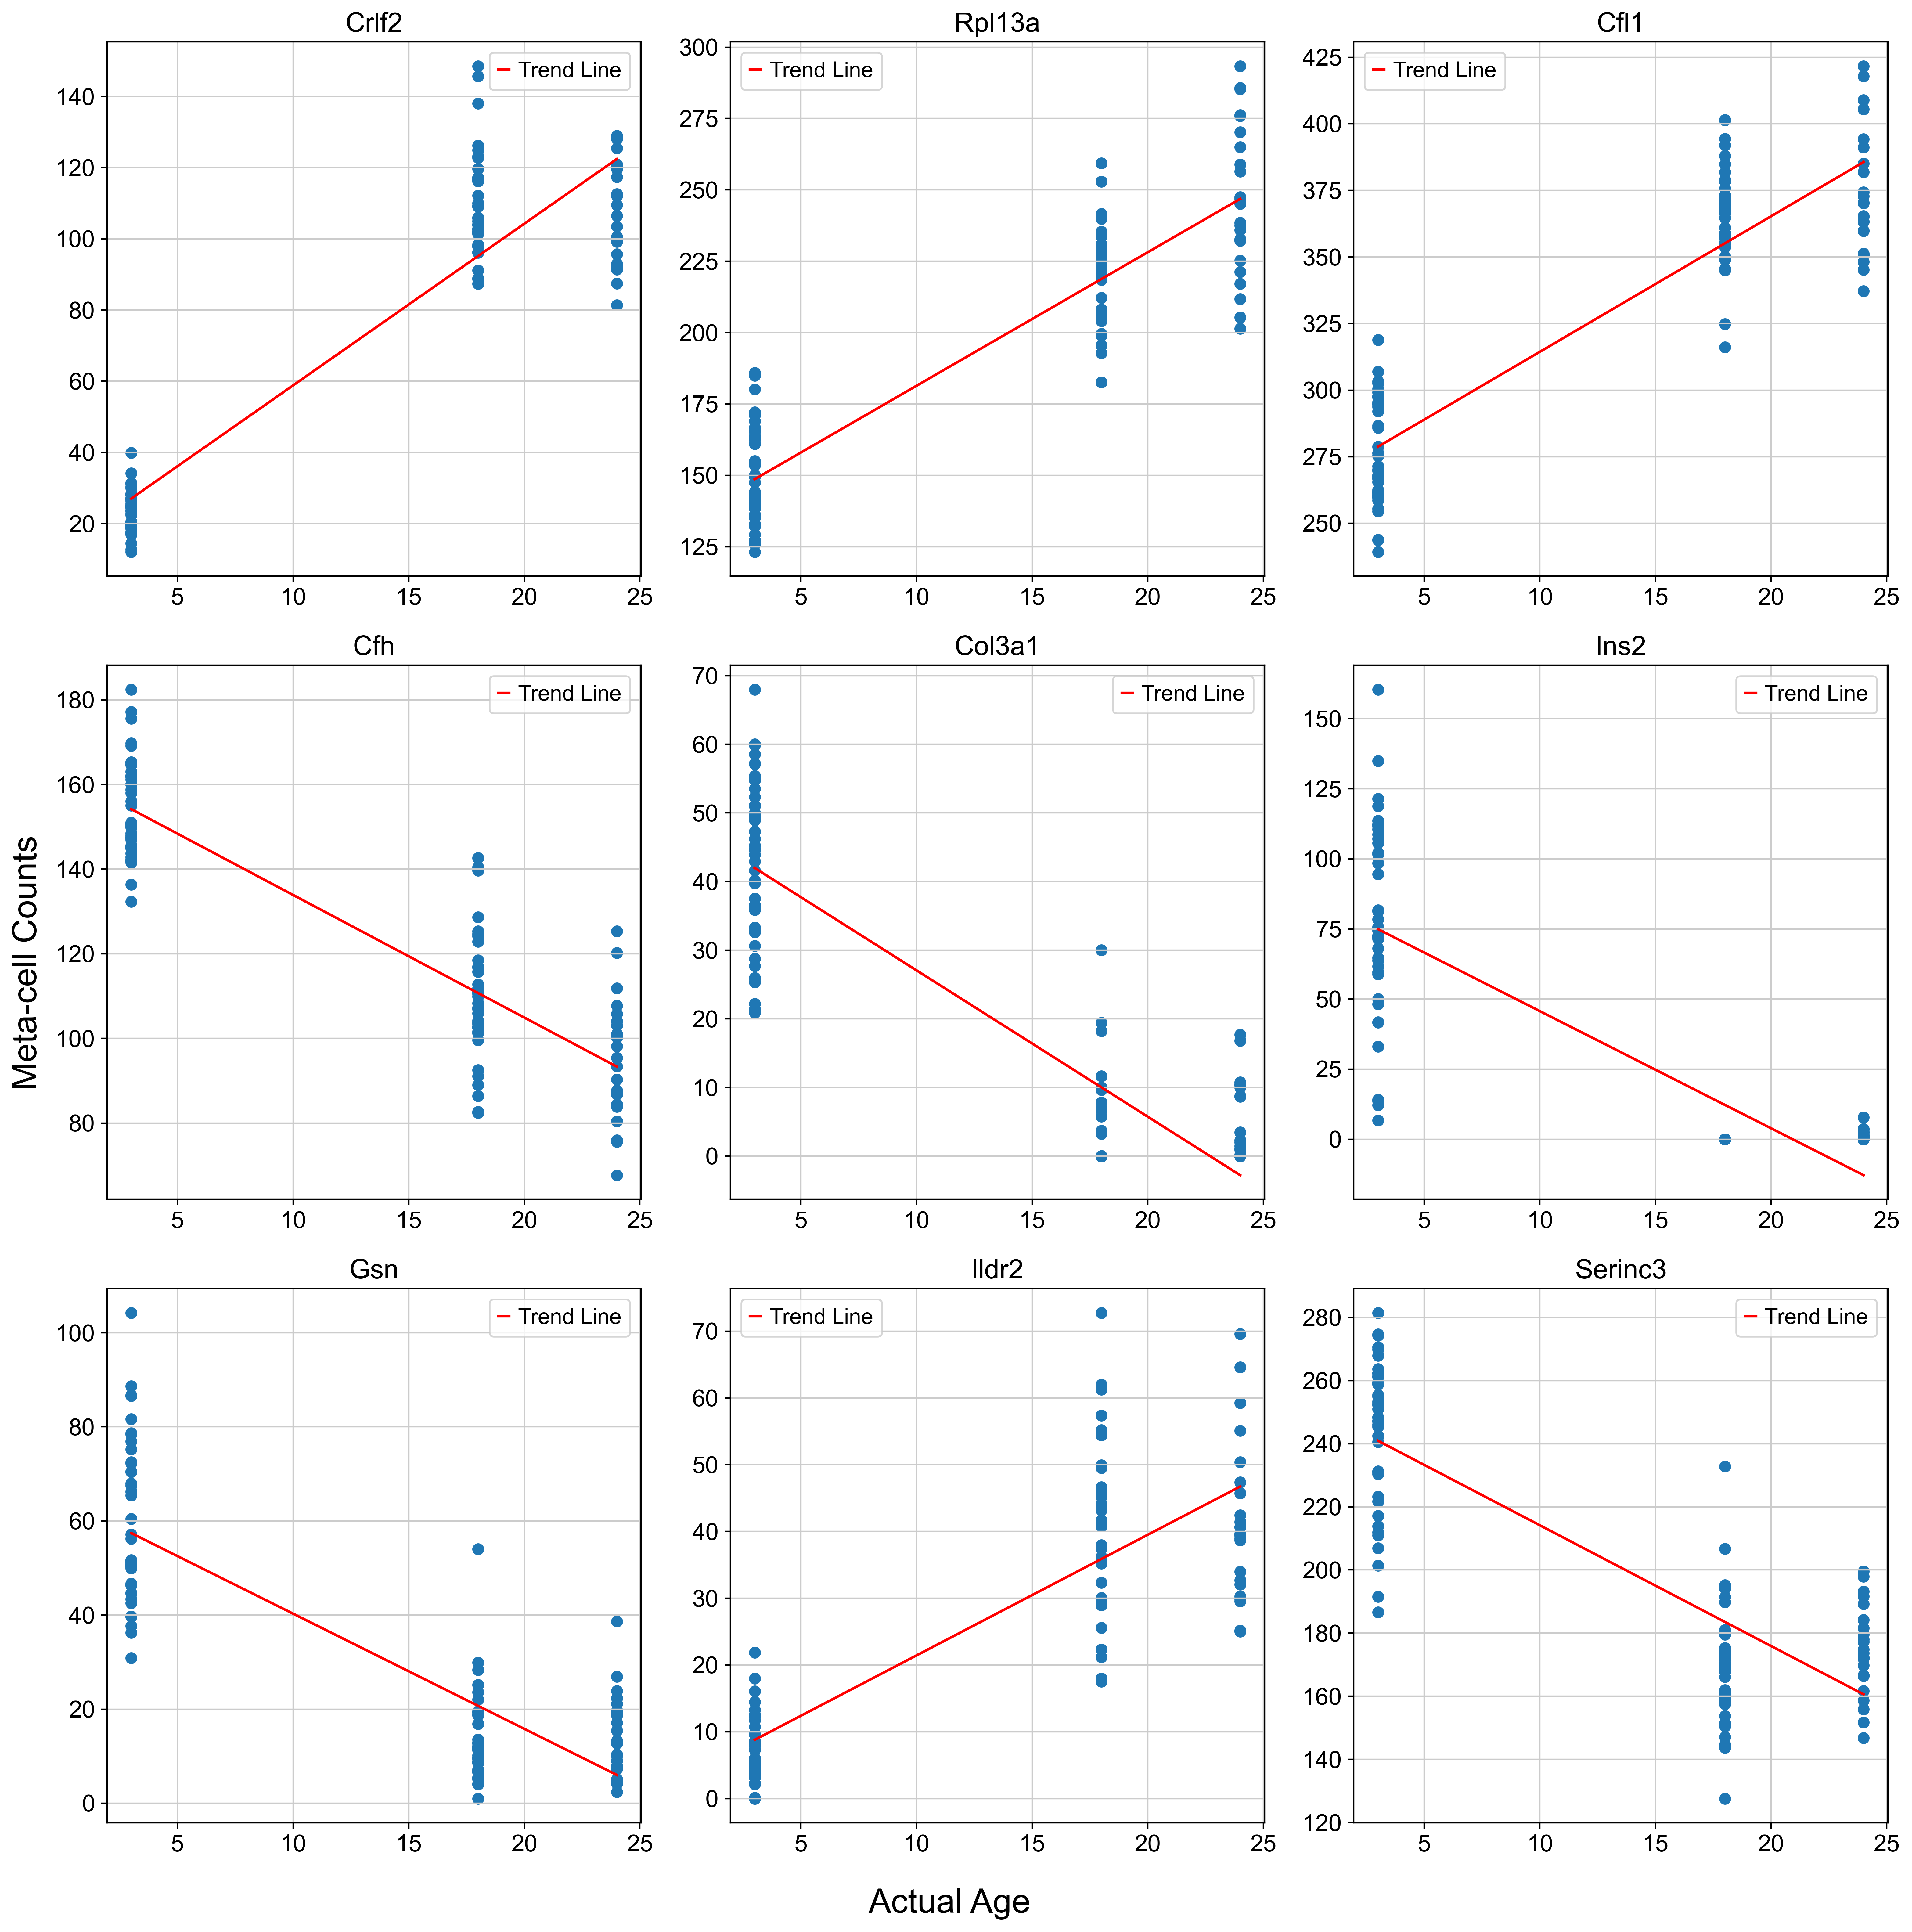

In [ ]:
import seaborn as sns
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["microglial cell"][:9]
test_exprs = []
test_ages = meta_cells_mapping_ages["microglial cell"]
print(len(test_ages))
test_cells = meta_cells_per_celltype["microglial cell"]
for i in tqdm(range(len(genes))):
    gene_exprs = test_cells[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()
figure.supylabel("Meta-cell Counts", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
figure.savefig("./Brain_Microglial_MetaCell_Counts.png")
plt.show()

### plotting the frequency


100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 848.55it/s]


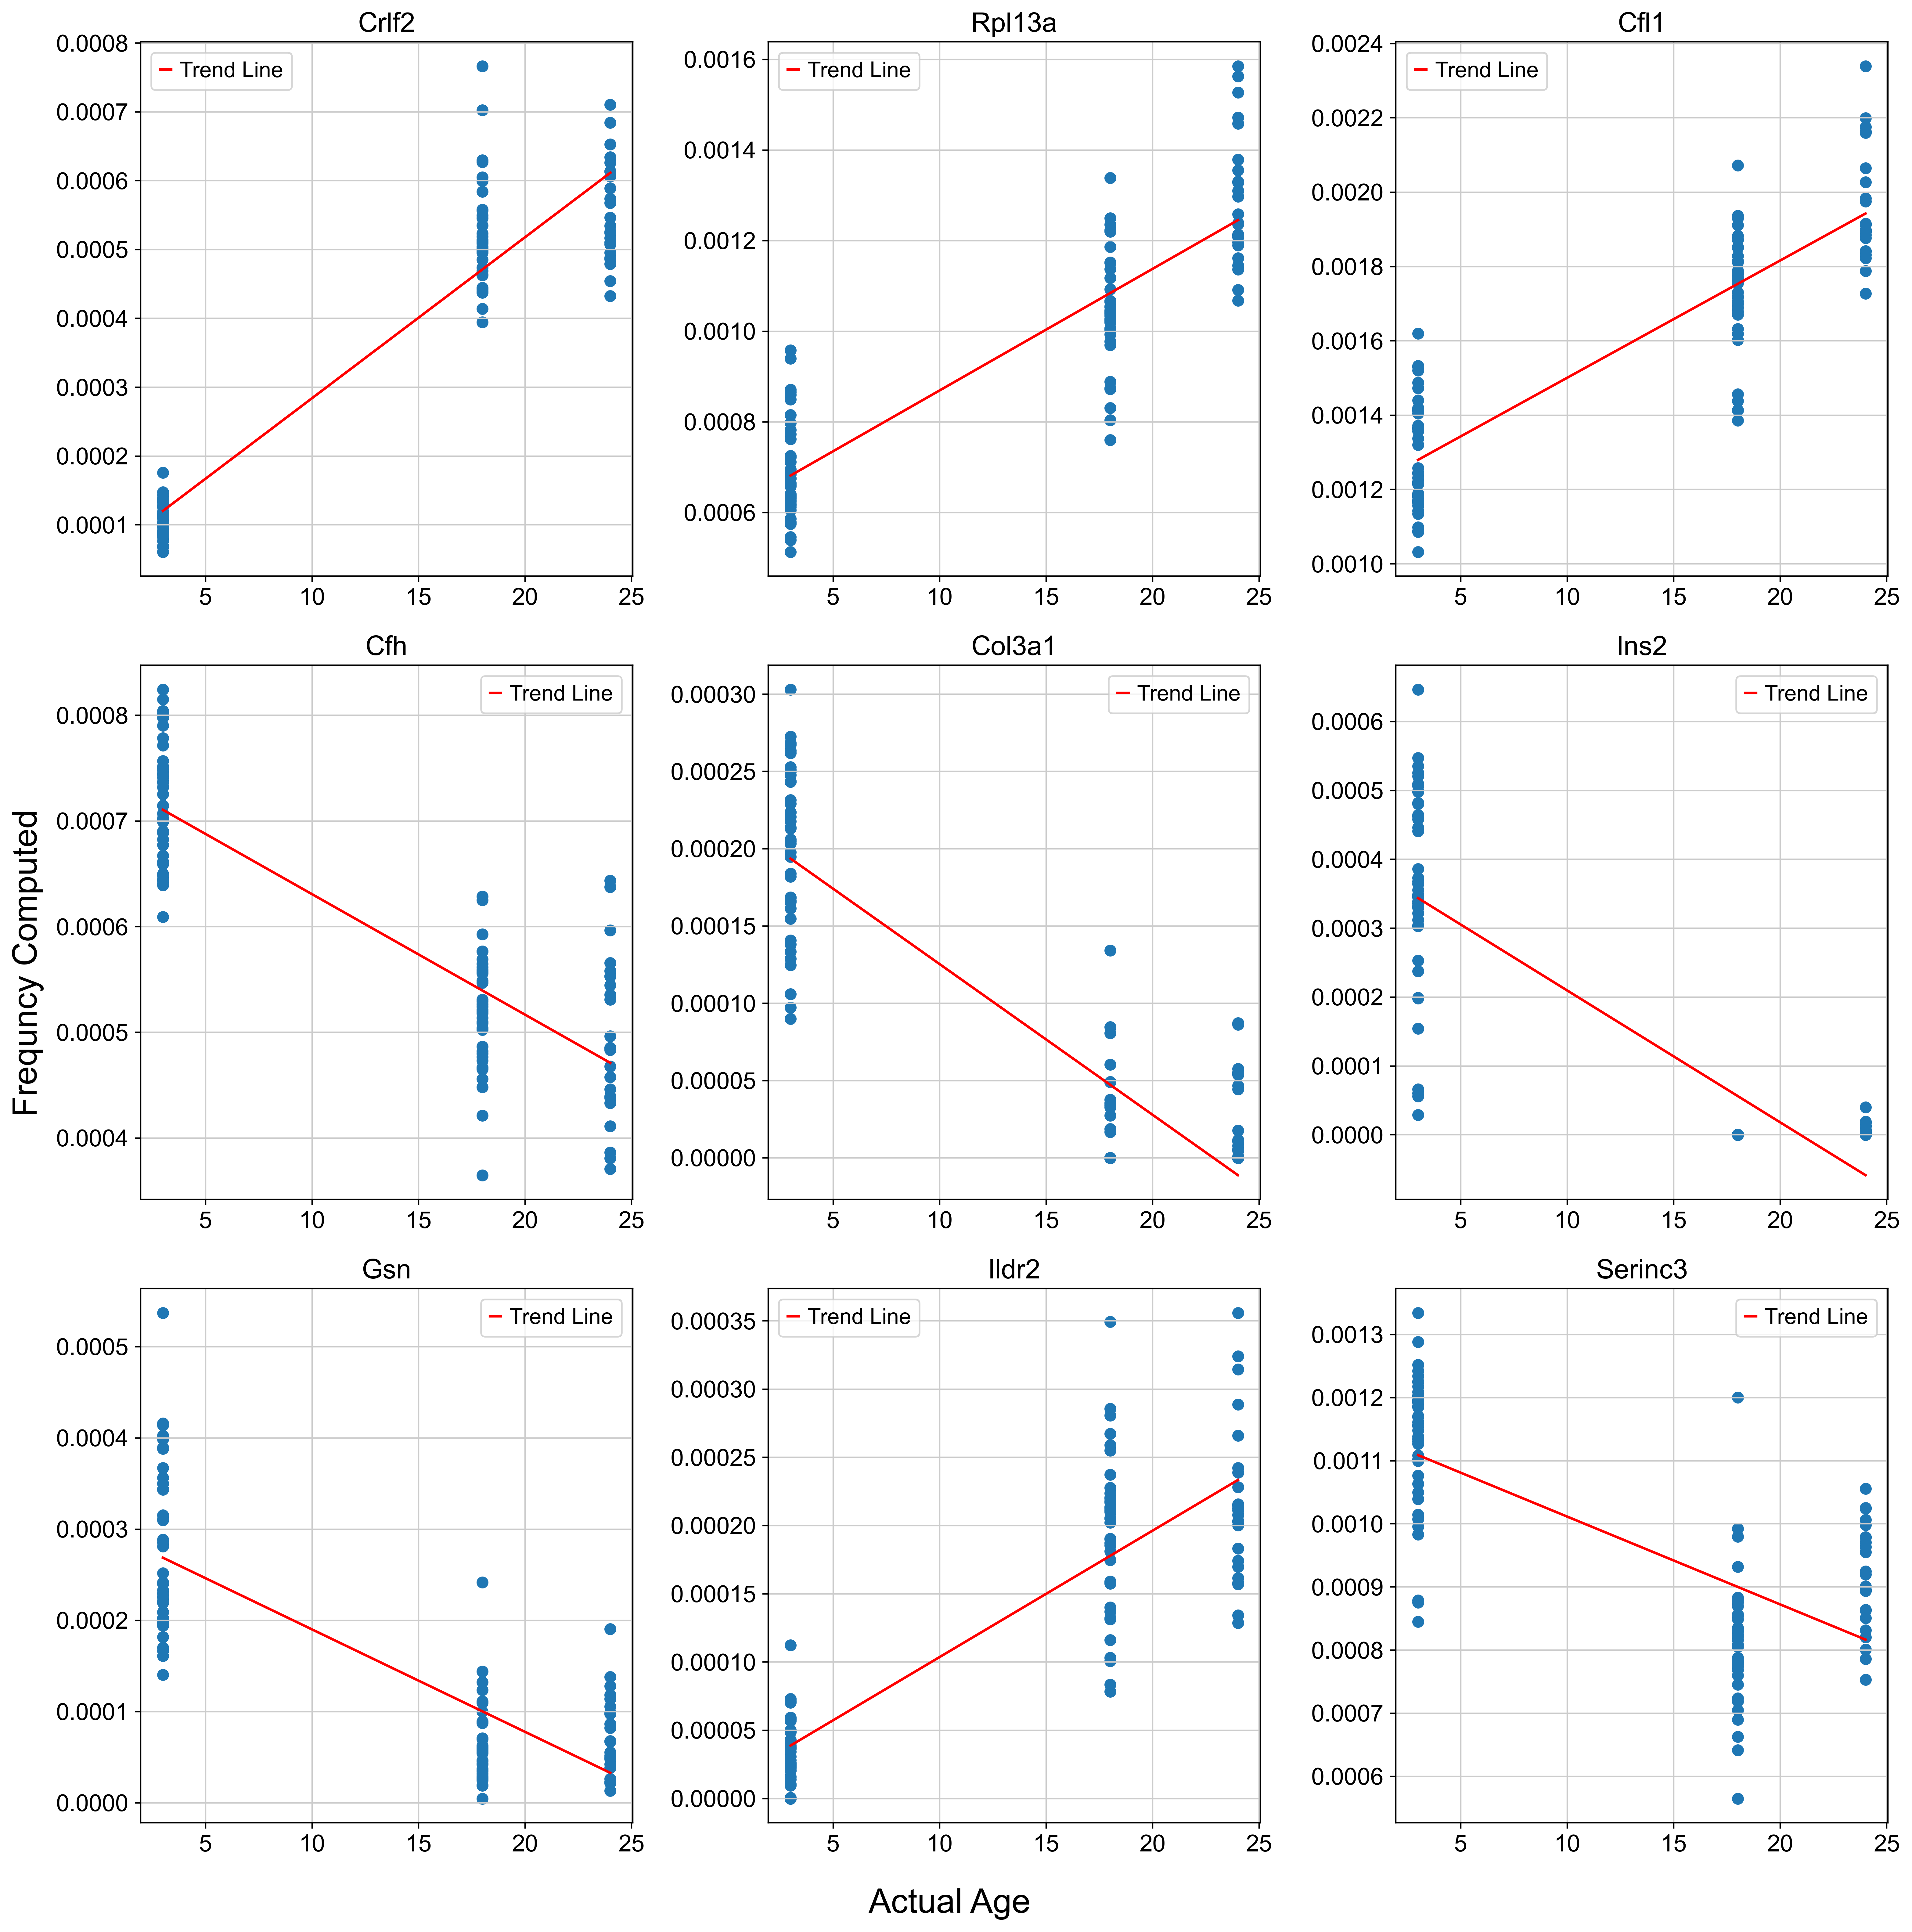

In [ ]:
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["microglial cell"][:9]
test_exprs = []
test_ages = list(freq_matrices["microglial cell"].columns)
test_freqs = freq_matrices["microglial cell"].loc[genes,]
for i in tqdm(range(len(genes))):
    gene_exprs = test_freqs.loc[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()
figure.supylabel("Frequncy Computed", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
figure.savefig("./Brain_Microglial_Frequncy.png")
plt.show()

### plotting the trend line (linear) result of the frequency

100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 1047.24it/s]


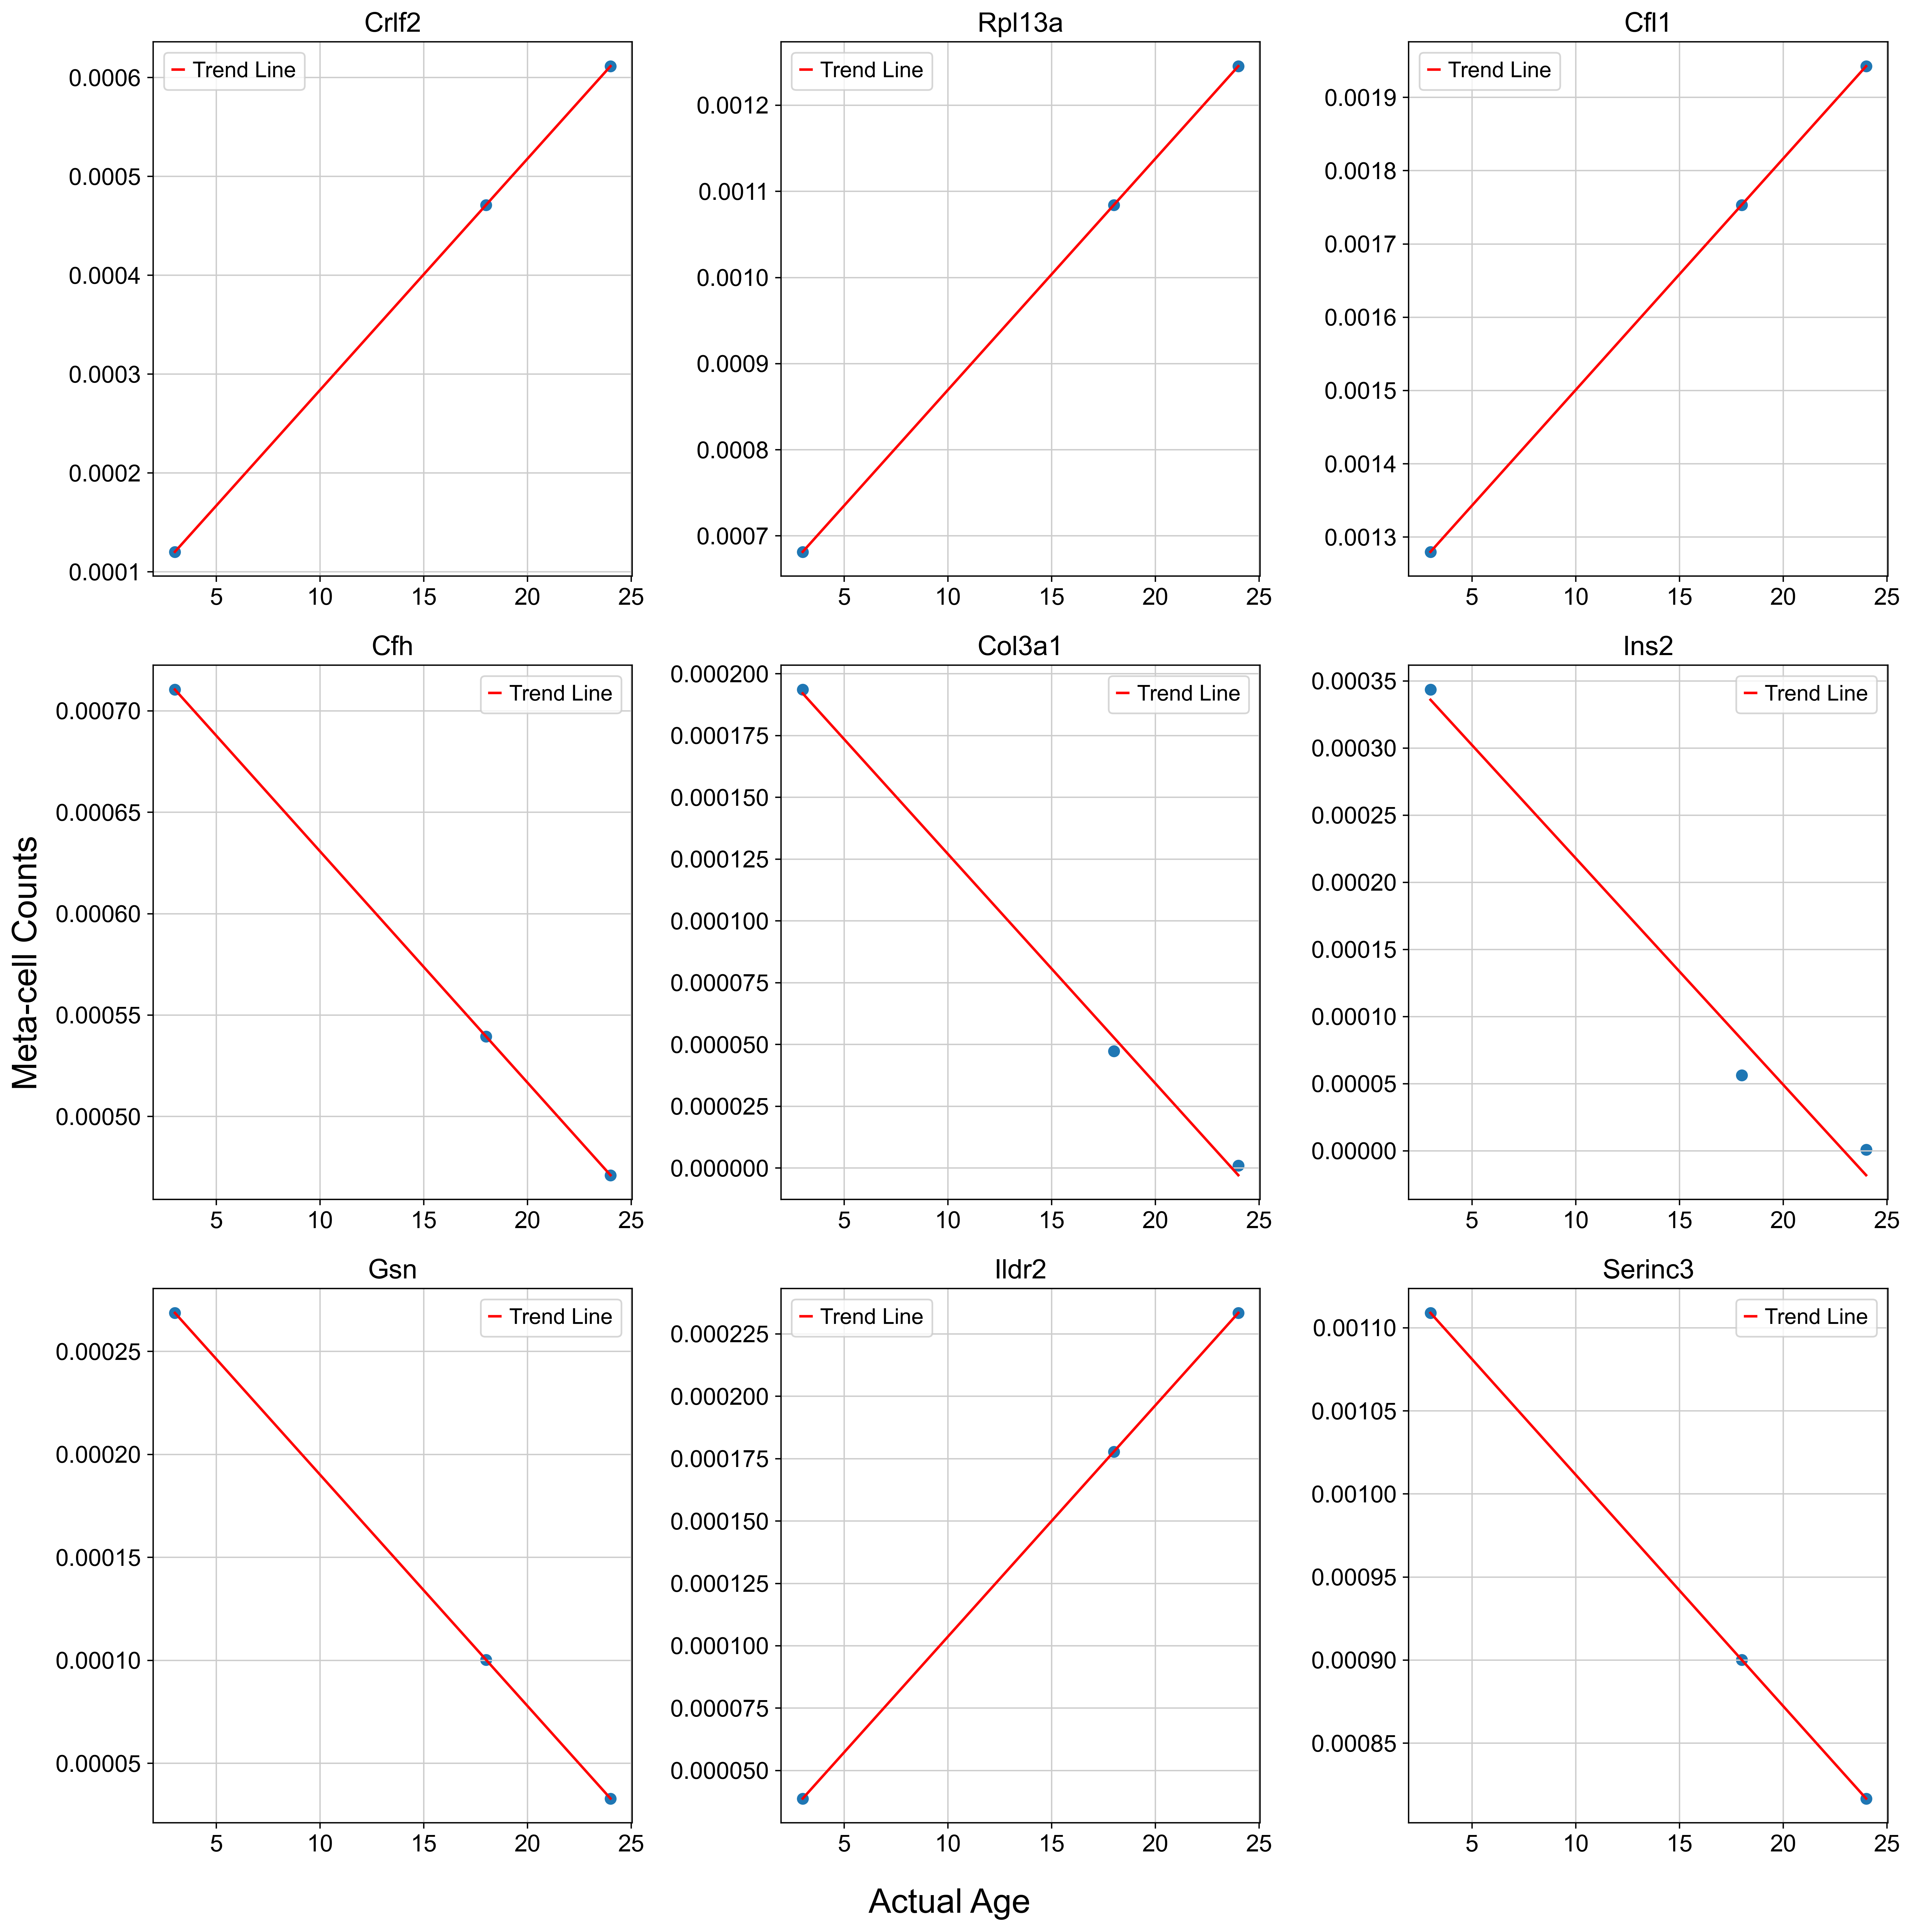

In [ ]:
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["microglial cell"][:9]
test_exprs = []
test_ages = list(pred_freq_matrices["microglial cell"].columns)
test_freqs = pred_freq_matrices["microglial cell"].loc[genes,]
for i in tqdm(range(len(genes))):
    gene_exprs = test_freqs.loc[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()
figure.supylabel("Meta-cell Counts", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
plt.show()

## Run Poisson

In [ ]:
from scipy.stats import poisson
import math
from numpy import inf

In [ ]:
from collections import defaultdict
def get_cells_byAge(cell_group):
    cell_group_ages = age_df.T[cell_group.index]
    cell_group_age_dict = defaultdict(list)
    for cell in cell_group_ages:
        cell_group_age_dict[cell_group_ages[cell].values[0]].append(cell)
    return cell_group_age_dict

In [ ]:
def get_singleCell_sums(cells):
    cell_sums = np.sum(cells, axis = 0)
    return(cell_sums)

In [ ]:
from numpy import inf
def run_poisson(celltype, pred_freqs, raw_cells, age_classes):
    outcome = defaultdict(list)
    freq_probs = defaultdict(list)
    for age in pred_freqs:
#         print(f"-----processing {age}--------")
        cell_group_byAge = get_cells_byAge(raw_cells)
        cell_group = raw_cells.T[cell_group_byAge[age]]
        cell_sums = get_singleCell_sums(cell_group)
        for cell in cell_group:
            _lambda = pred_freqs * cell_sums[cell] # frequency of that gene expression * counts of all genes in that cell
            prob = poisson.pmf(np.array(cell_group[cell]).reshape(-1,1), _lambda)
            max_value = np.log(prob)
            max_value[max_value == -inf] = 0
#             temp = np.sum(max_value, axis = 0).reshape(1,-1)
            freq_probs[age].append(np.sum(max_value, axis = 0))
            age_poss = age_classes[np.argmax(np.sum(max_value, axis = 0))]
            outcome[age].append(age_poss)
    
    pred_results[celltype] = outcome
    likelihood[celltype] = freq_probs
    actual_ages = []
    for key in list(outcome.keys()):
        actual_ages.extend(len(outcome[key]) * [key])
    
    return actual_ages, [int(inner) for outer in list(outcome.values()) for inner in outer]

In [ ]:
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def plot_violin(ax, x, y, name):
    data = pd.DataFrame({
    'Ages': x,
    'Predicted': y})
    mae = mean_absolute_error(x, y)
    pearson_rsquared = pearsonr(x, y)[0]**2
    spearman_rsquared = spearmanr(x, y)[0]**2
    
    record_r_squared(name, pearson_rsquared)
    
#     save_csv(name, pearson_rsquared, spearman_rsquared)

   
    sns.violinplot(x='Ages', y='Predicted', data=data, palette='Set2', ax=ax)

#   TODO: Create the half violin plot
    
    ax.text(0.64, 0.98, f'MAE: {mae:.2f}, $pearson^2$: {pearson_rsquared:.2f}, $spearman^2$: {spearman_rsquared:.2f}', 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=14, 
            bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Predicted Age", fontsize = 16)
    ax.set_xlabel("True Age", fontsize = 16)
    ax.set_title(name, fontsize = 16)

In [ ]:
# def plot_cell_count(ax, cellCount_dict):
#     sns.barplot(x=list(cellCount_dict.keys()), y=list(cellCount_dict.values()), palette='Set2', ax=ax)
#     ax.set_title('Num of Cells for Each Age', fontsize = 16)
#     ax.set_xlabel('Age', fontsize = 16)
#     ax.set_ylabel('Count', fontsize = 16)
#     # Adding text labels above bars using seaborn.barplot object
#     for i, value in enumerate(cellCount_dict.values()):
#         ax.text(i, value, f'{int(value)}', ha='center', va='bottom', fontsize=10, color='black')

In [ ]:
def plot_cell_count(ax, train_cellCount_dict, test_cellCount_dict):
    ages = sorted(list(train_cellCount_dict.keys()))
    
    # Convert the dictionaries to lists of values for seaborn
    train_counts = list(train_cellCount_dict.values())
    test_counts = list(test_cellCount_dict.values())
    
    bar_width = 0.4
    # Set position of bars on X axis
    r1 = np.arange(len(ages))
    r2 = [x + bar_width for x in r1]
    
    # Use different colors for each x value
    unique_colors = sns.color_palette("Set2", len(ages))

    for i in range(len(ages)):
        ax.bar(r1[i], train_counts[i], color=unique_colors[i], width=bar_width, edgecolor='grey', label=f'Train (Age {ages[i]})')
        ax.bar(r2[i], test_counts[i], color=unique_colors[i], alpha=0.7, width=bar_width, edgecolor='grey', label=f'Test (Age {ages[i]})')
    
    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Num of Cells for Each Age (Train vs Test)', fontsize=16)
    ax.set_xticks([r + bar_width / 2 for r in range(len(ages))])
    ax.set_xticklabels(ages)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Add text labels above bars for train and test counts
    for i, value in enumerate(train_counts):
        ax.text(r1[i], value, f'{int(value)}', ha='center', va='bottom', fontsize=10, color='black')
    
    for i, value in enumerate(test_counts):
        ax.text(r2[i], value, f'{int(value)}', ha='center', va='bottom', fontsize=10, color='black')

In [ ]:
def record_r_squared(celltype, r_squared):
    file_path = "../r_squareds/Brain_r_squared_summary.csv"
    # Create a new DataFrame with celltype as the index and r_squared value
    df = pd.DataFrame({'R_squared': [r_squared]}, index=[celltype])
    
    if not os.path.isfile(file_path):
        df.to_csv(file_path, mode='w')
    else:
        # If the file exists, append the new data
        df.to_csv(file_path, mode='a', header=False)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Processing cell type: microglial cell
[ 3 18 24]
{1: 0.10076979551438922, 2: 0.050502067623707195, 4: 0.027488116148909097, 8: 0.24753637340002815, 16: 0.4017948340219206, 32: 0.531697750983389, 64: 0.5859627096884207, 128: 0.5779185000036577, 256: 0.37346847800016697, 512: 0.3488079783223581, 1024: 0.3568302988637016, 2048: 0.47099623715512823, 4096: 0.5853231955230078}
Model using 64 numbers of genes


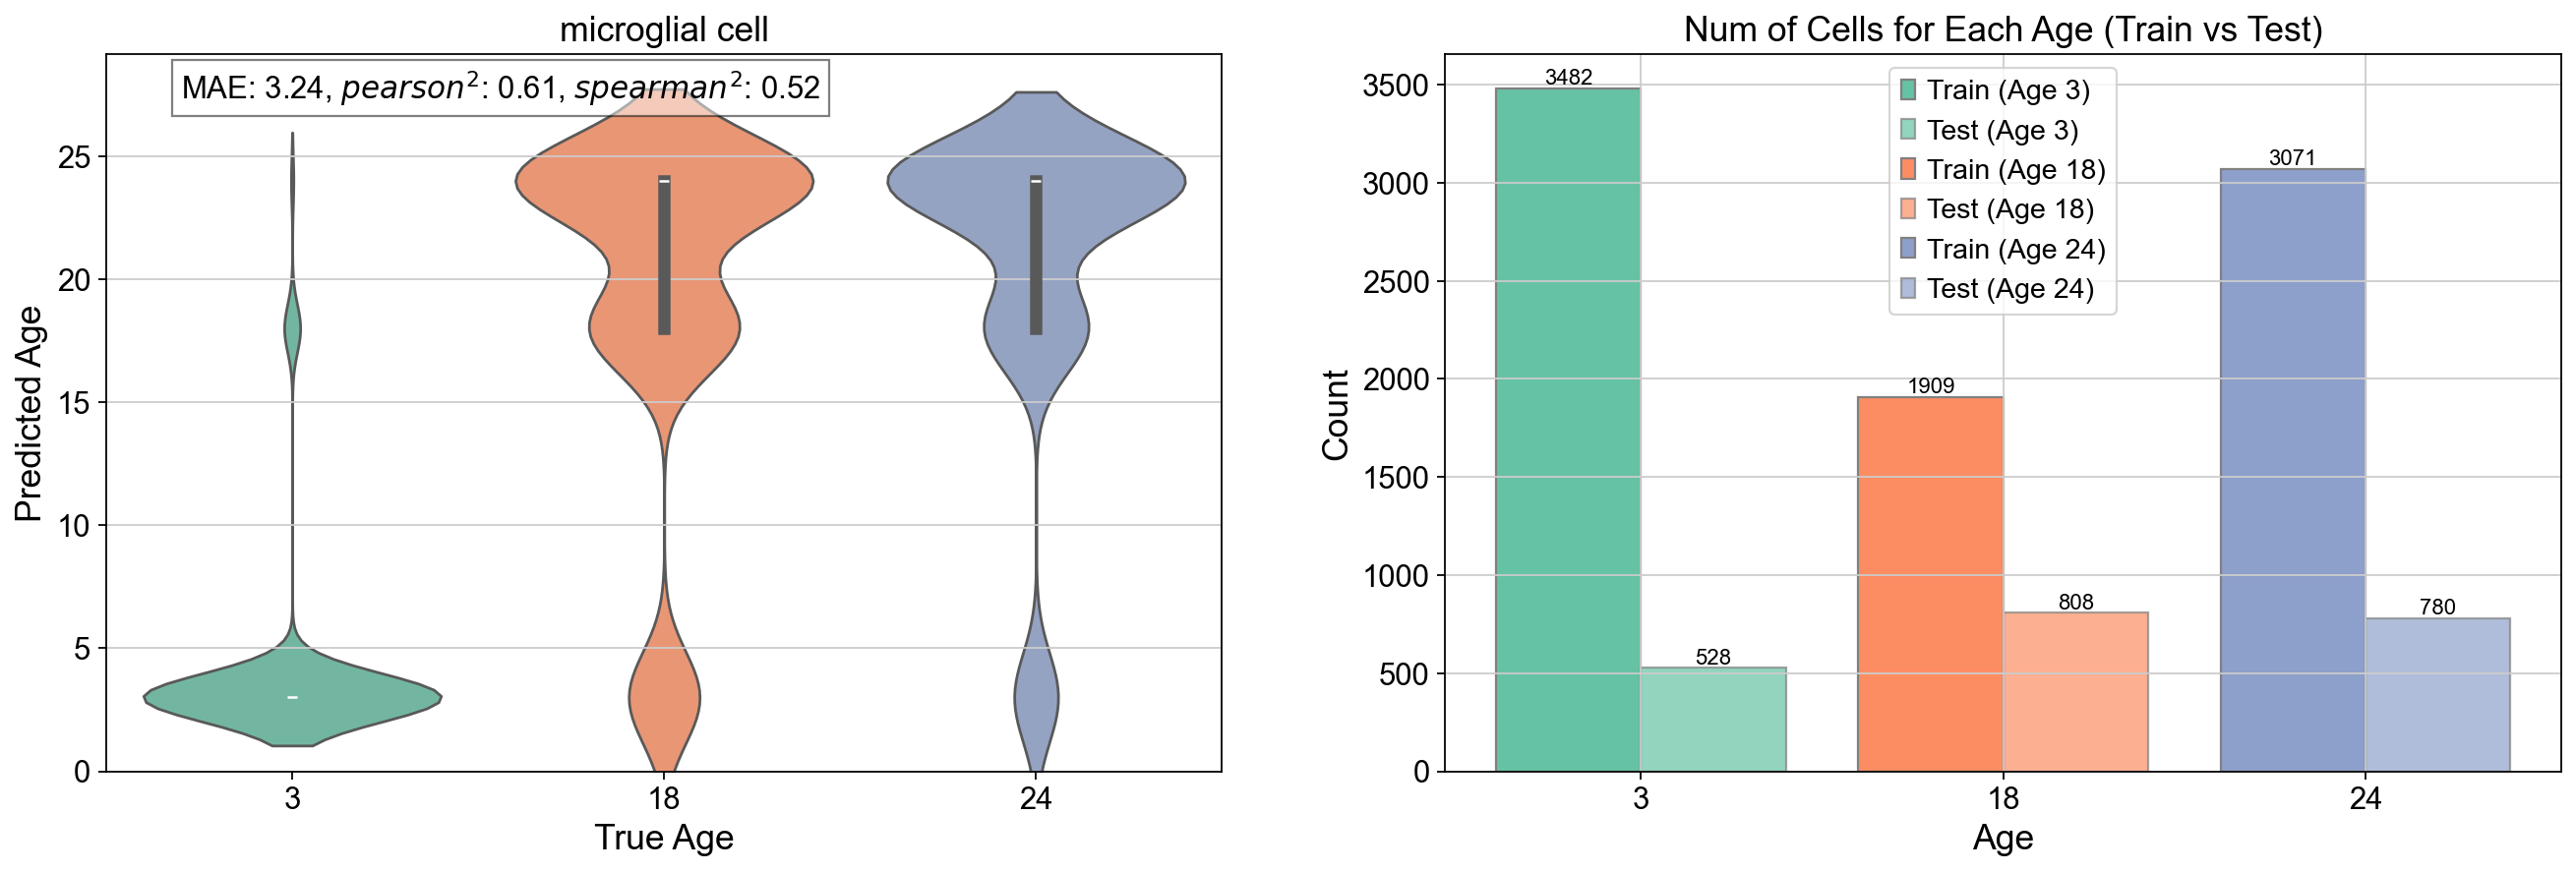

Processing cell type: oligodendrocyte
[ 3 18 24]
{1: 0, 2: 0, 4: 0, 8: 0, 16: 0, 32: 0, 64: 0, 128: 0, 256: 0, 512: 0, 1024: 0.005862073677924063, 2048: 0.08940015263561966, 4096: 0.43736664197792313}
Model using 4096 numbers of genes


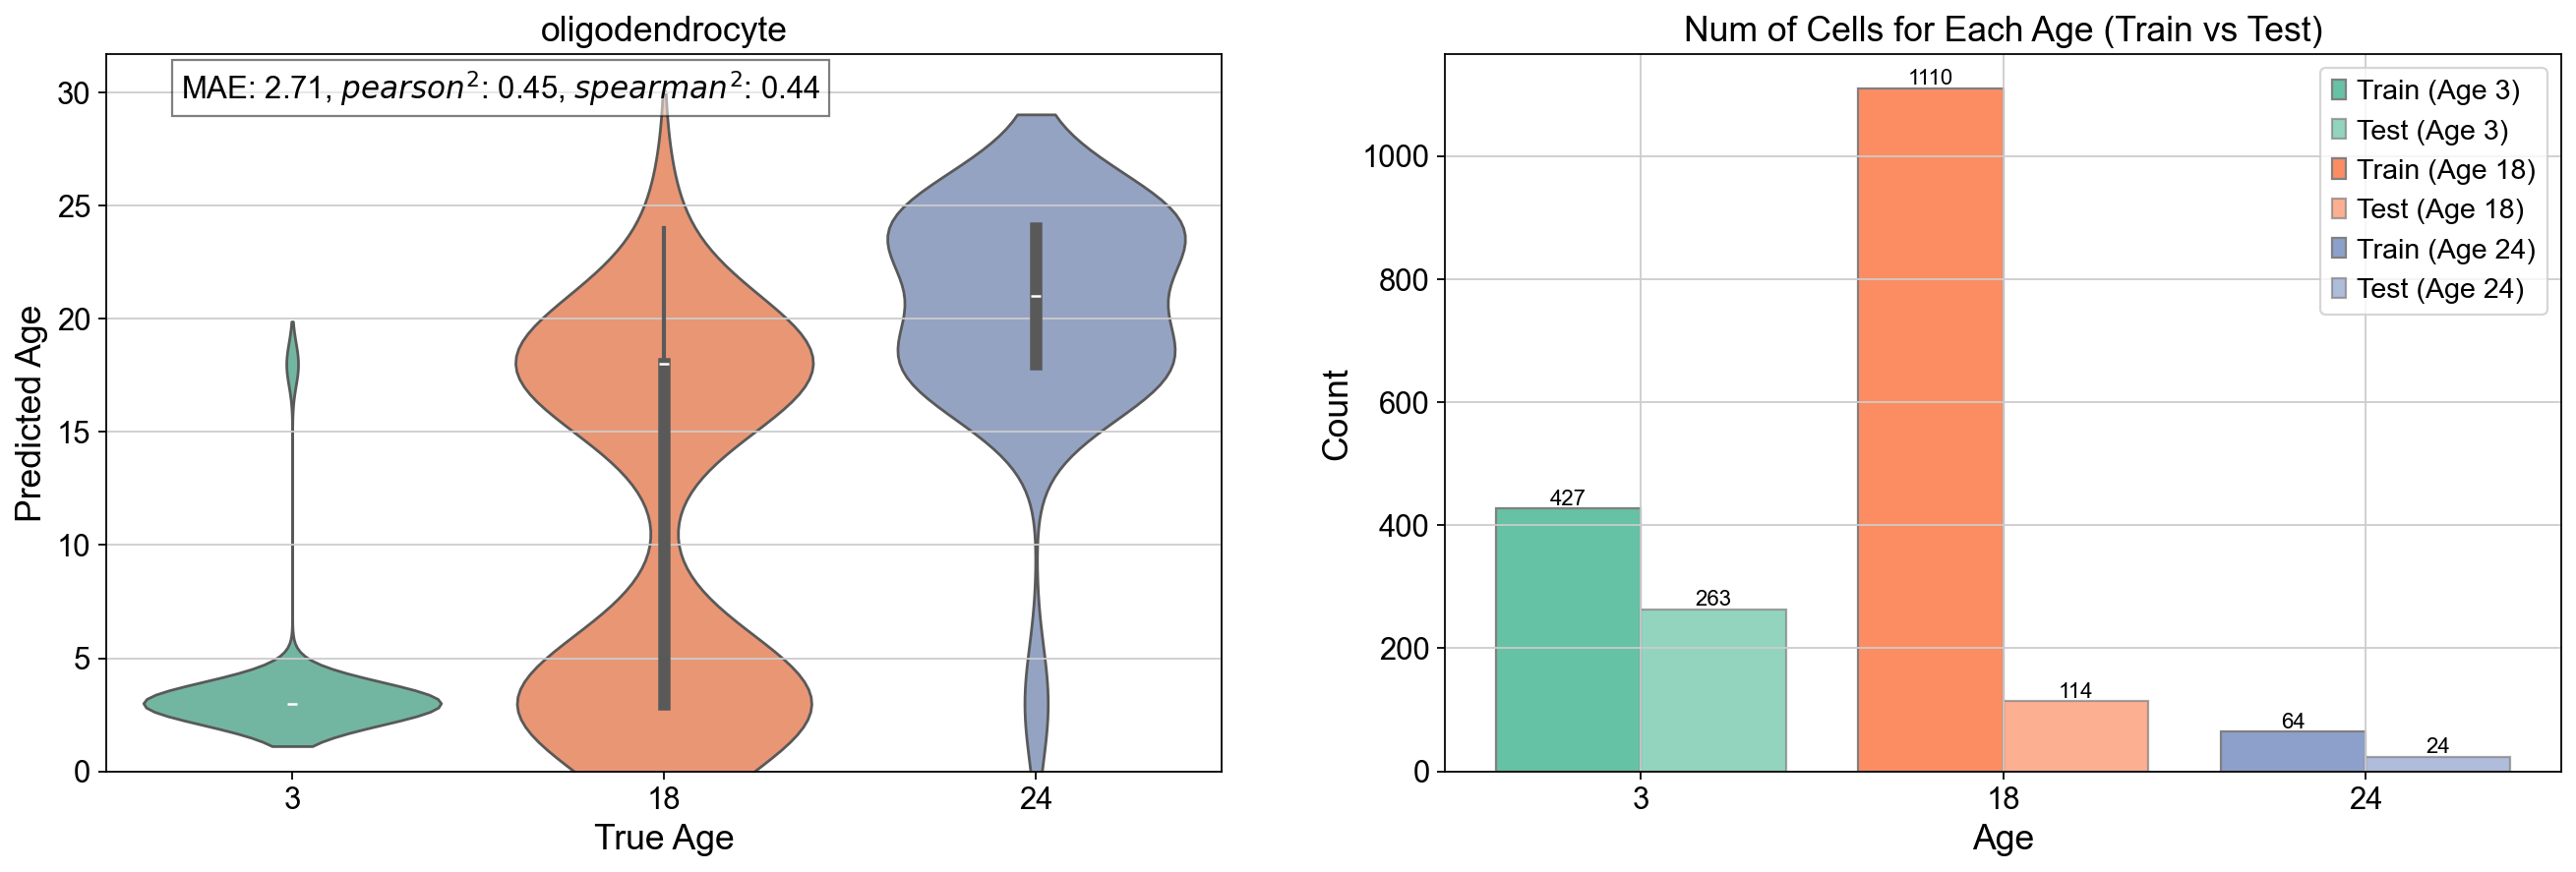

Processing cell type: astrocyte
[ 3 18 24]
{1: 0.001660510507228894, 2: 0.0007711214775440991, 4: 0.0075552660873952635, 8: 0.01993165542842279, 16: 0.023647144229772925, 32: 0.019619371649621516, 64: 0.020561863742562775, 128: 0.1140032685566137, 256: 0.15293910249767106, 512: 0.22236493873714955, 1024: 0.2914474448031663, 2048: 0.5570647733860387, 4096: 0.6650187418873275}
Model using 4096 numbers of genes


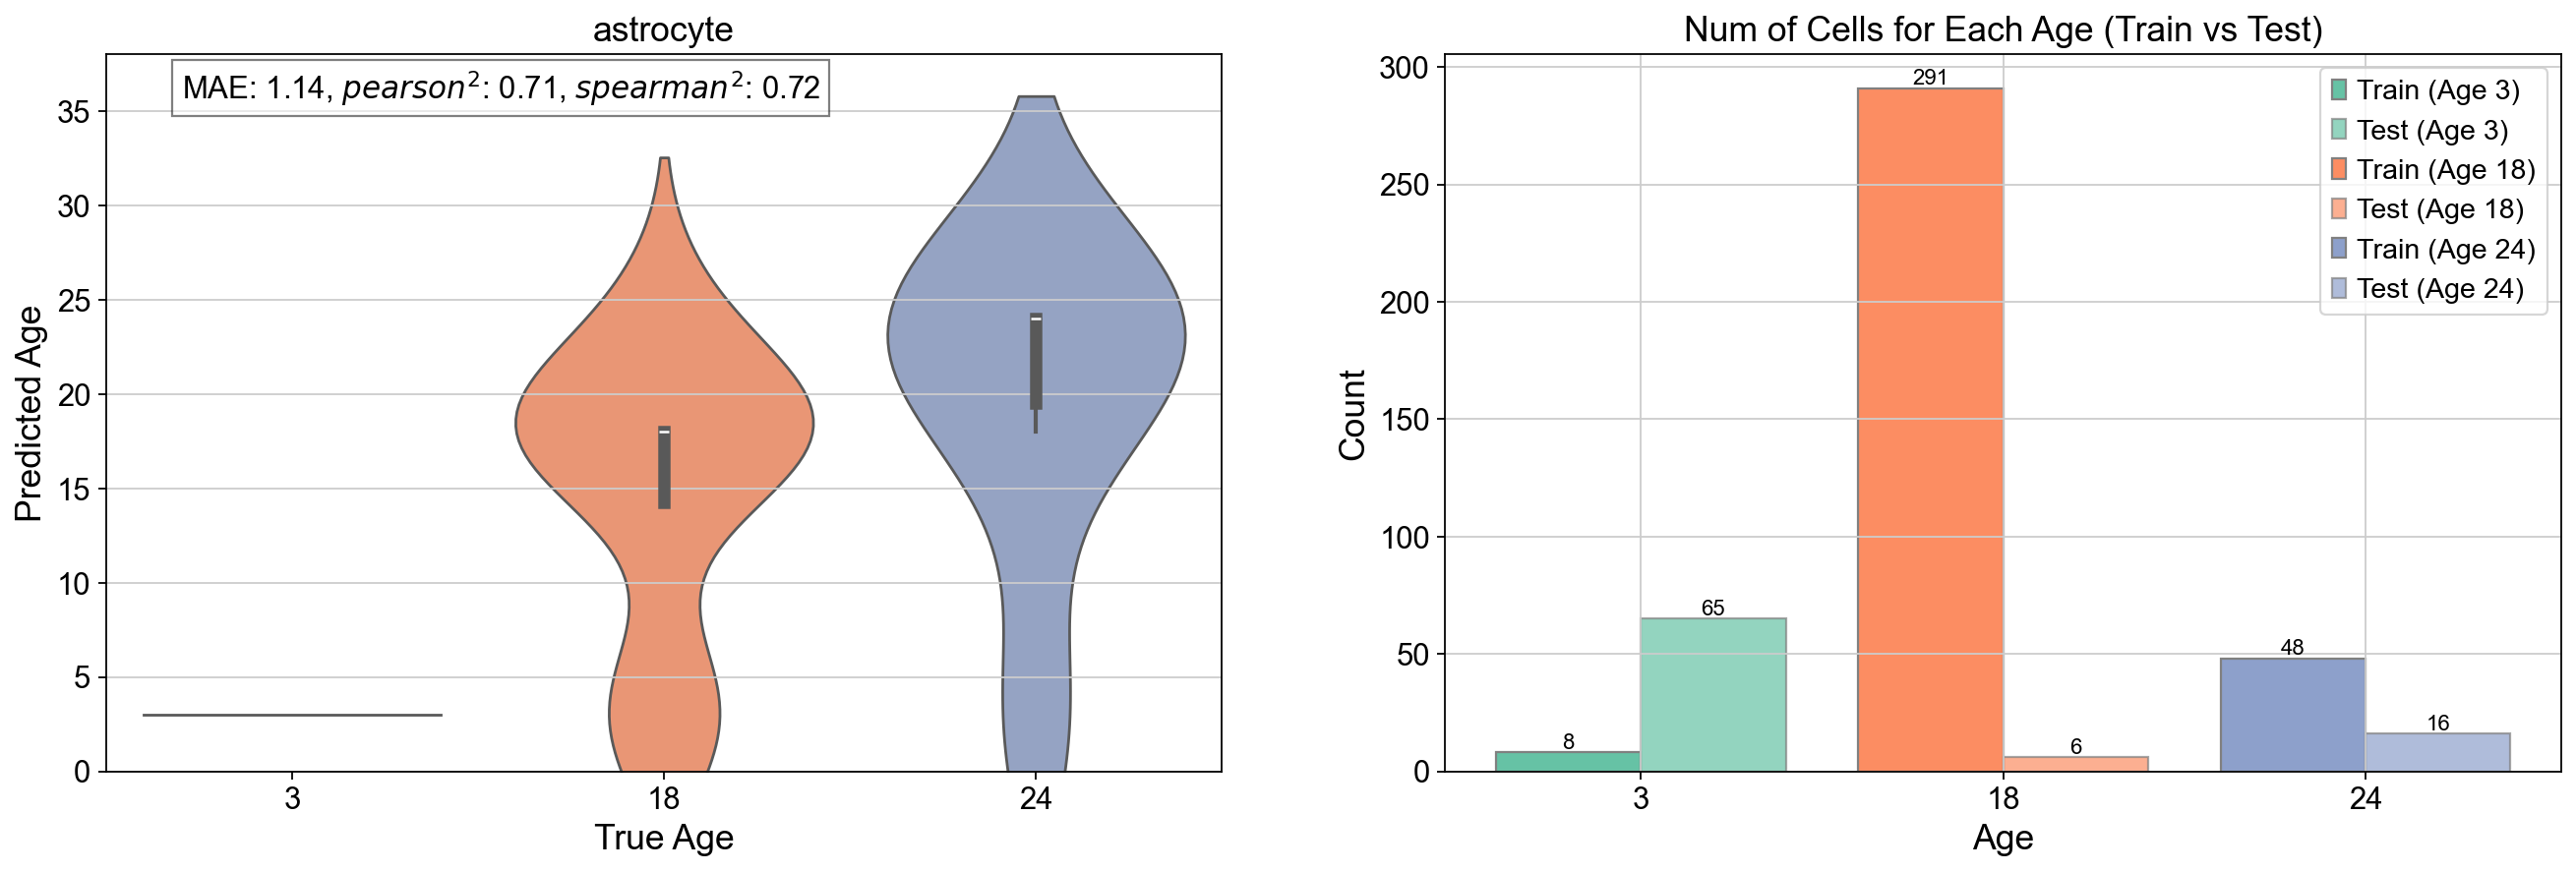

Processing cell type: brain pericyte
[ 3 18 24]
{1: 0.0024332312185526535, 2: 0.014878498031774424, 4: 0.032441419401055965, 8: 0.027252926327287166, 16: 0.03279387359353533, 32: 0.009930747800310516, 64: 5.342571543133892e-05, 128: 0.006393482214738073, 256: 0, 512: 0, 1024: 0, 2048: 0, 4096: 0.4354226022715914}
Model using 4096 numbers of genes


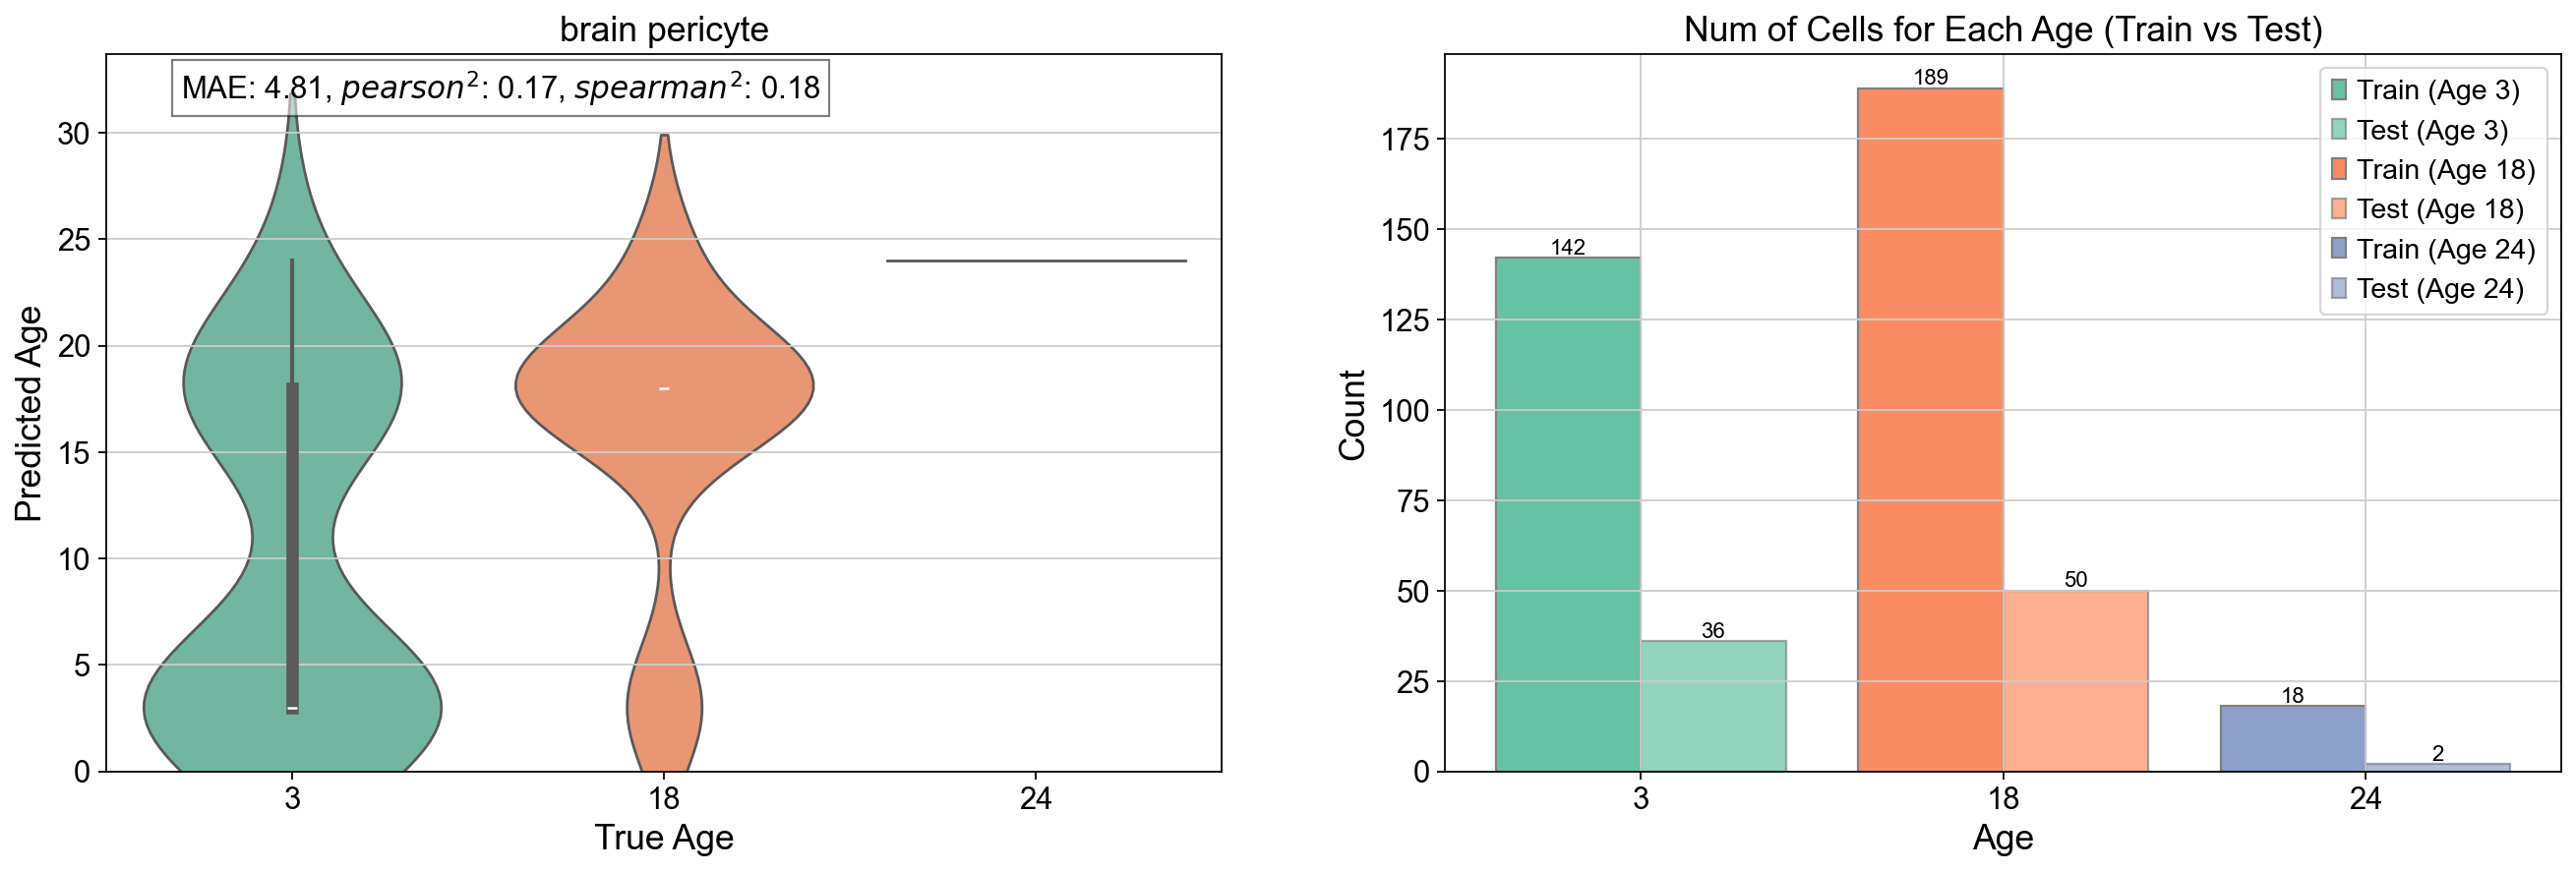

Processing cell type: endothelial cell
[ 3 18 24]
{1: 0, 2: 0, 4: 0, 8: 0, 16: 0.0024657724384476716, 32: 0.001359886170481589, 64: 0.0010832364057411818, 128: 0, 256: 0, 512: 0, 1024: 0.0013598861704815913, 2048: 0.022899279761890903, 4096: 0.2379642589935484}
Model using 4096 numbers of genes


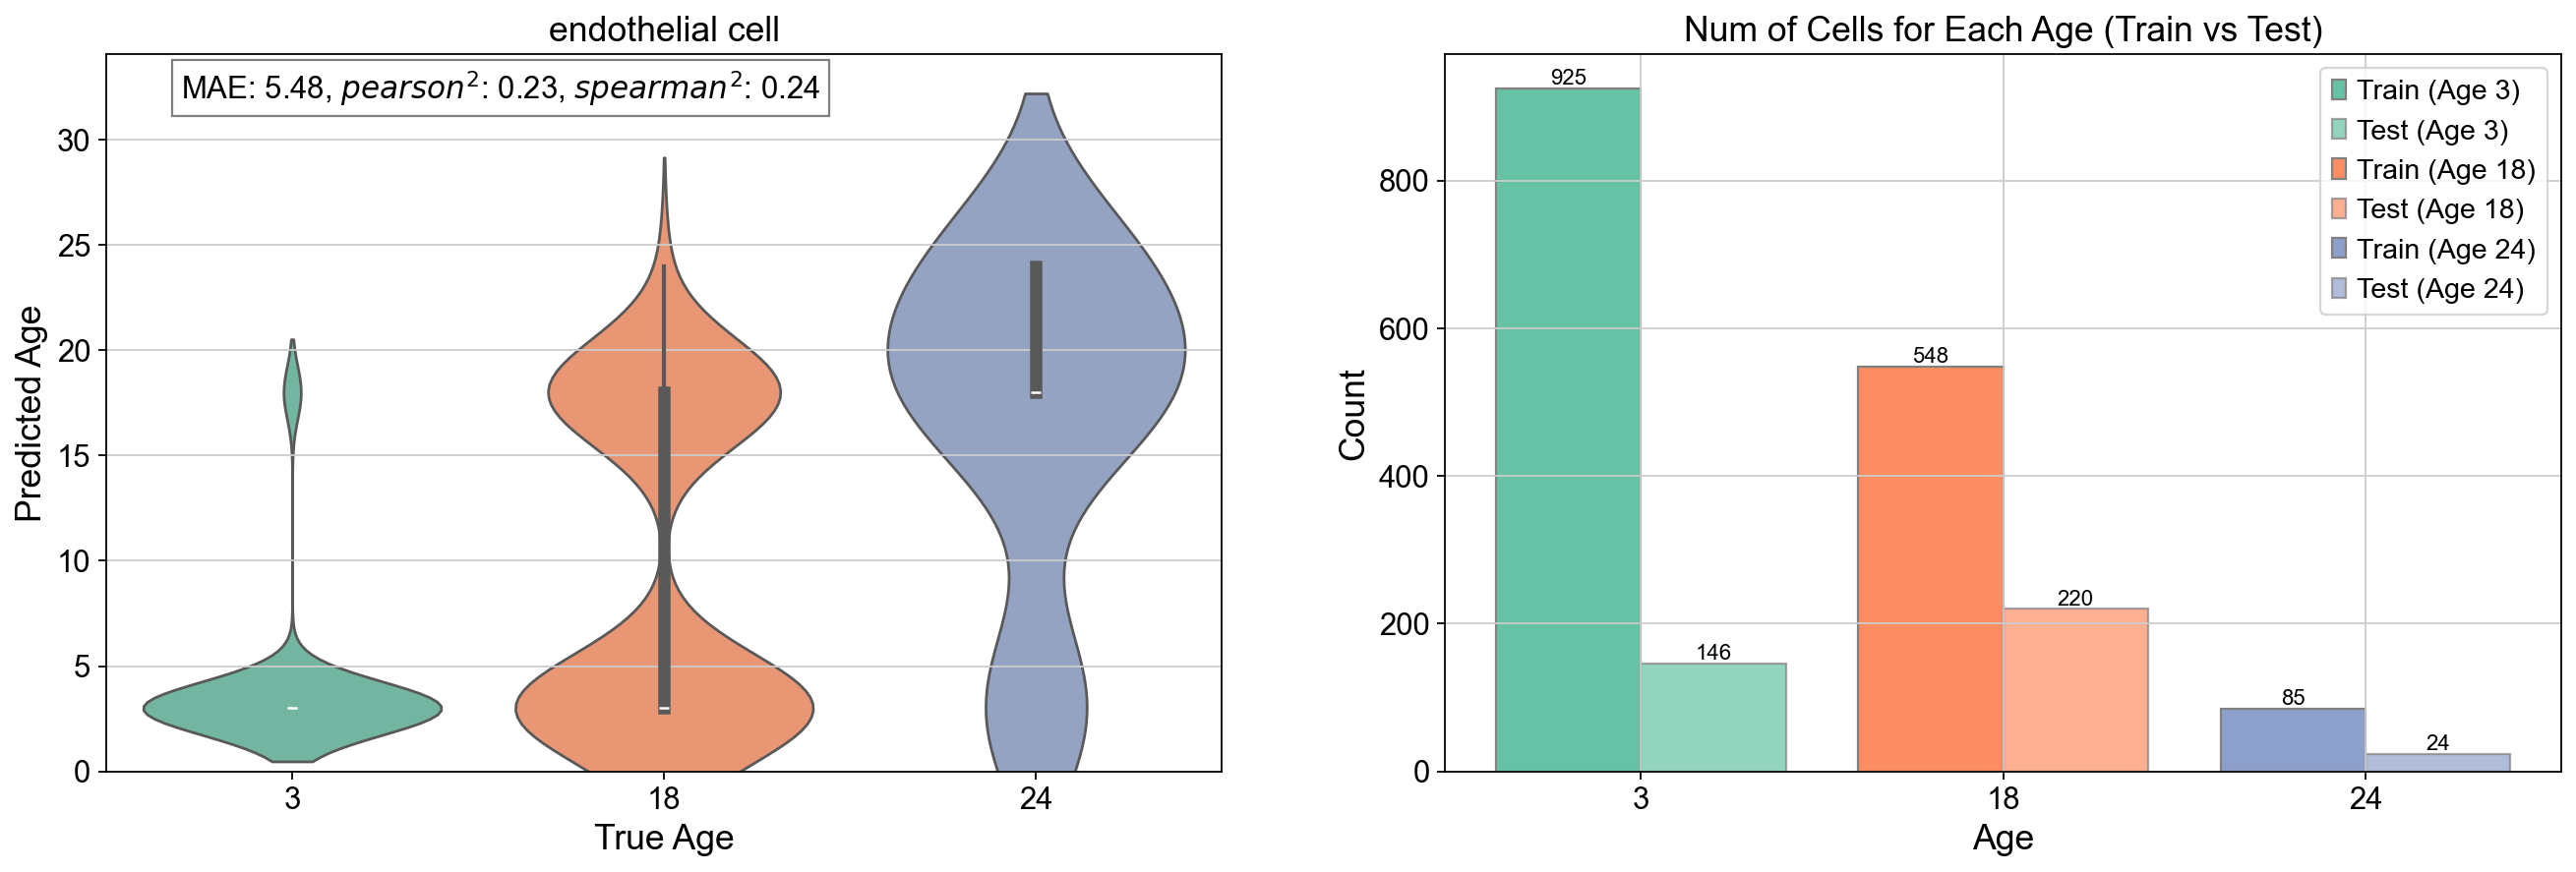

Processing cell type: neuron
[ 3 18 24]
{1: 0.2709743858641051, 2: 0.2688938447358772, 4: 0.28438960657636486, 8: 0.23356883249593238, 16: 0.17596688411810057, 32: 0.1670187676163365, 64: 0.2063523159209498, 128: 0.15378805377983376, 256: 0.22984167463963798, 512: 0.24035452141191954, 1024: 0.3575344997067185, 2048: 0.4366716909533261, 4096: 0.6516857155455902}
Model using 4096 numbers of genes


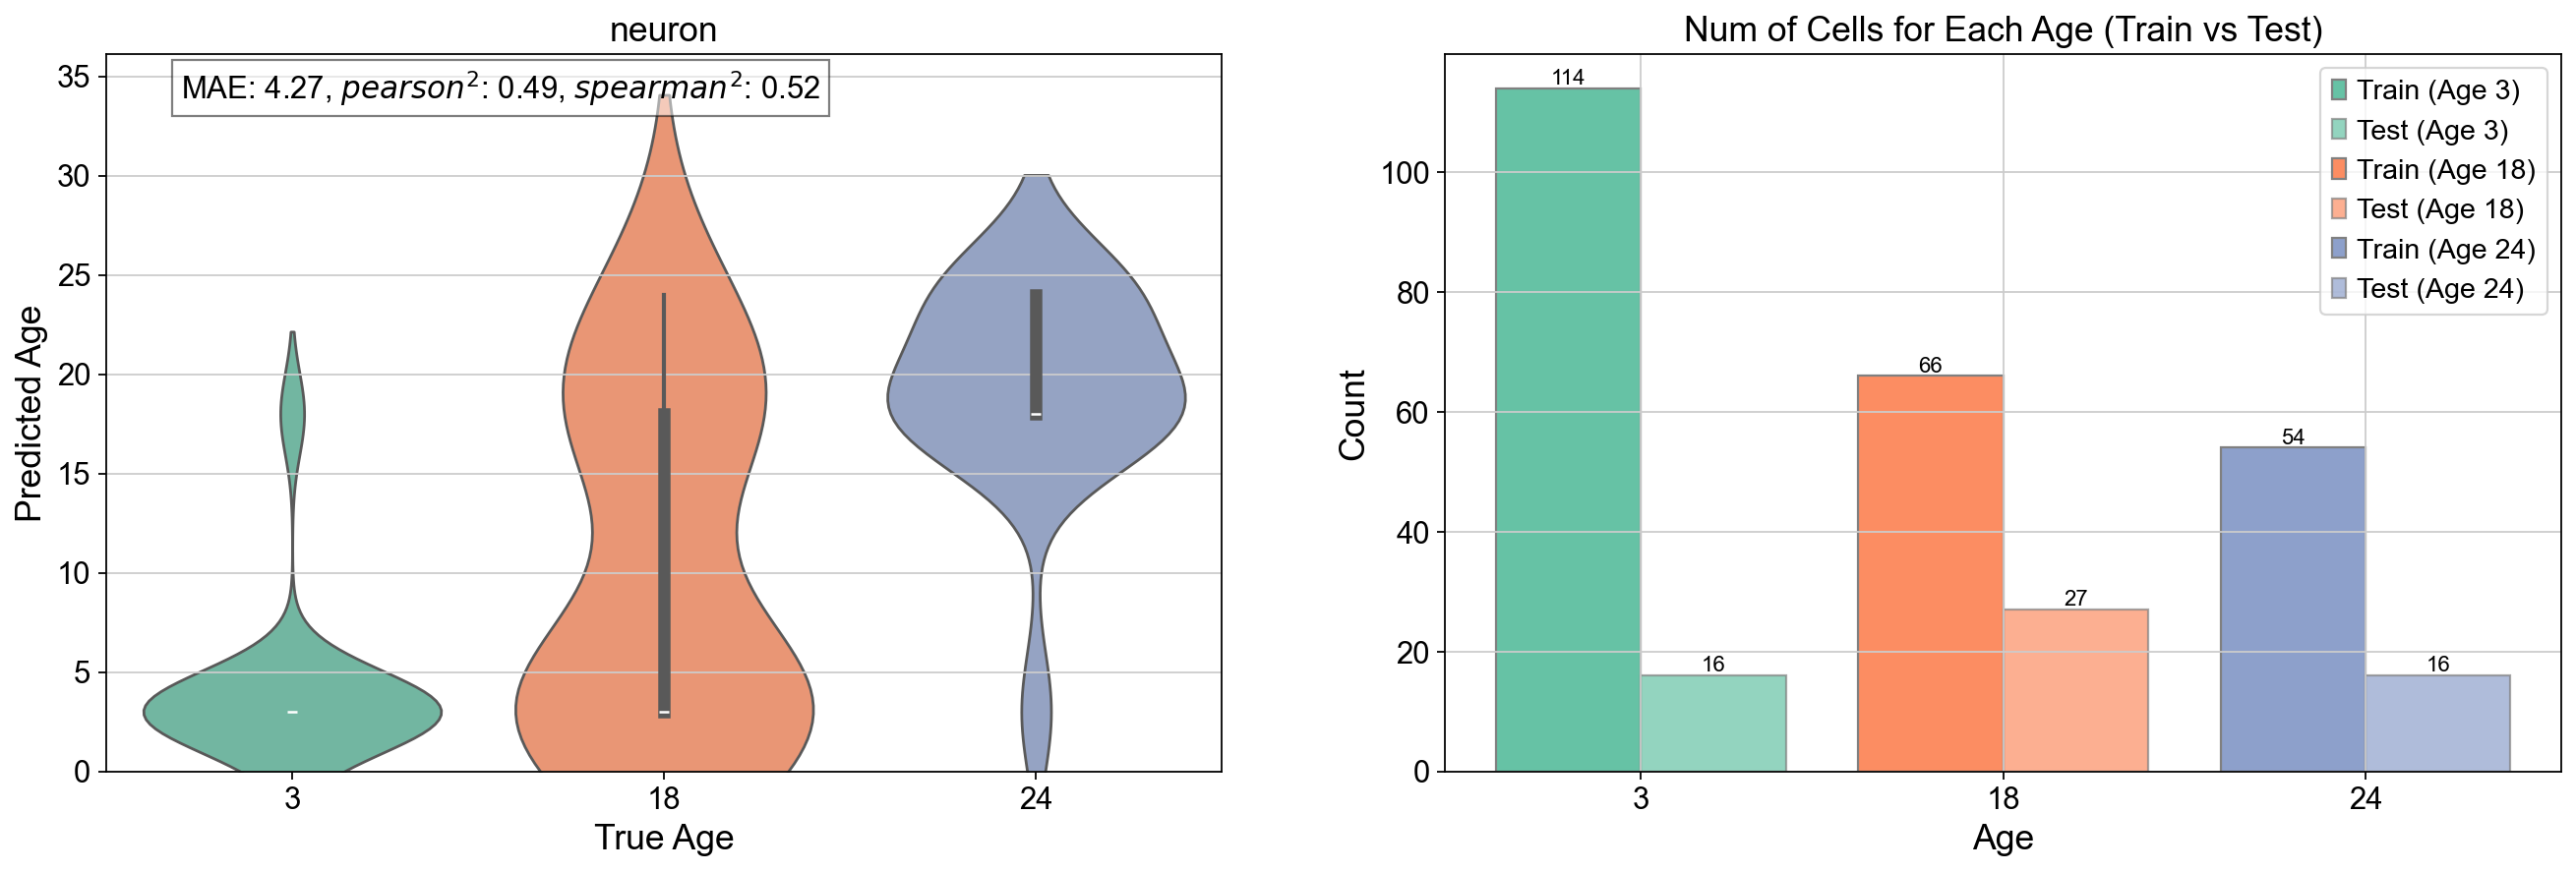

In [ ]:
pred_results = {}
likelihood = {}

from sklearn.metrics import log_loss  # To calculate cross-entropy
from sklearn.model_selection import train_test_split

# Dictionary to store r_squared values for each cell type and gene count
r_squared_results = {}

# Iterate over each cell type in the predicted frequency matrices
for celltype in pred_freq_matrices:
    print(f"Processing cell type: {celltype}")
    
    raw_cells = pd.DataFrame(raw_count[celltype_dict[celltype]])
    ages = age_df.T[raw_cells.columns]
    
    # Split the cells into 80% training and 20% testing
    train_age, test_age = train_test_split(
        ages.T, test_size=0.2, random_state=42)
    
    train_cells = raw_cells[train_age.index].T
    test_cells = raw_cells[test_age.index].T
    
    # Select the correlated genes for the current cell type
    correlated_gene_list = correlated_genes[celltype]
    
    # Retrieve the training ages for the current cell type
    train_age_data = np.unique(train_age_groups[celltype])
    print(train_age_data)
    
    # Store cross-entropy results for different gene counts
    celltype_r_squared = {}
    
    i = 0
    while (2**i) <= len(correlated_gene_list) / 2:
        gene_count = 2**i
        i += 1
        selected_genes = correlated_gene_list[:gene_count]
        # Retrieve the predicted frequency matrix for the current cell type
        pred_freqs = pred_freq_matrices[celltype].loc[selected_genes]
        
        # Filter raw cells to include only the top 'num_genes' correlated genes
        filtered_train_cells = train_cells[selected_genes]
    
        # Run the poisson function
        true_ages, predicted_ages = run_poisson(celltype, pred_freqs, filtered_train_cells, train_age_data)
        
        # get the pearsonr
        pearson_rsquared = pearsonr(true_ages, predicted_ages)[0]**2
        celltype_r_squared[gene_count] = pearson_rsquared
    
    # Store cross-entropy results for the cell type
    r_squared_results[celltype] = {num_genes: (np.max(r_squareds) if not np.isnan(r_squareds).any() else 0) for num_genes, r_squareds in celltype_r_squared.items()}
    print(r_squared_results[celltype])
    optimal_gene_counts = max(r_squared_results[celltype], key=r_squared_results[celltype].get)
    print(f"Model using {optimal_gene_counts} numbers of genes")
    
    selected_genes = correlated_gene_list[:optimal_gene_counts]
    pred_freqs = pred_freq_matrices[celltype].loc[selected_genes]
    filtered_test_cells = test_cells[selected_genes]
    true_ages, predicted_ages = run_poisson(celltype, pred_freqs, filtered_test_cells, train_age_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=80)
    
    plot_violin(ax1, true_ages, predicted_ages, celltype)
    plot_cell_count(ax2, Counter(train_age["age"]), Counter(test_age["age"]))
    plt.show()